# Explication du projet

Dans un précédent projet, une classification automatique des produits de la plateforme de Place de marché a été mise en place, et a permis d’assigner chaque produit à une catégorie de manière automatique. Cette première approche reposait sur l’utilisation du modèle VGG16, un réseau de neurones convolutifs, qui a servi de base pour établir une première solution et qui a permis de classer correctement 76% des produits de la plateforme. Le modèle pré-entraîné VGG16 a été utilisé grâce à une approche de transfert d'apprentissage pour extraire les caractéristiques visuelles des images, et l'ajout de plusieurs couches additionnelles a permis de classer les produits dans les catégories les plus probables. 

Afin d’améliorer la méthodologie existante et d’optimiser les performances obtenues, un nouvel algorithme, sera expérimenté dans ce notebook. Celui ci a été identifié après une revue de la littérature scientifique portant sur les méthodes récentes de classification d'images. L'analyse des publications scientifiques datant de moins de 5 ans ont ainsi permi d'identifier une architecture hybride prometteuse combinnant les capacité d'extraction locale des réseaux de neurones convolutifs avec la puissance des mécanismes d'attention issus des transformers. Cette approche innovante et découverte pas Wu et ses collaborateurs en 2021 se nomme le Convolutional vision Transformer.

L’approche déjà développée servira de point de comparaison et sera reprise comme référence. Le modèle CvT sera testé en parallele afin d’évaluer l’apport de ce type d’architecture hybride. Les résultats issus des deux méthodes seront ensuite comparés selon plusieurs scores de performance (exactitude, précision, rappel, temps d'entrainement, et robustesse sur de nouvelles données), ce qui permettra d’évaluer de manière rigoureuse l’apport de cette nouvelle approche et de déterminer si elle constitue une amélioration significative par rapport à la solution déjà en place.

# Sommaire
- [1 Explication du projet](#Explication-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-bibliothèques-et-des-données)
- [4 Préparation des données](#Préparation-des-données)
- [5 Retour sur la première approche : modèle VGG16 associé à de l'augmentation de données](#Retour-sur-la-première-approche:-modèle-VGG16-associé-à-une-étape-de-data-augmentation)
- [6 Nouvelle approche :  CvT avec data augmentatio](#Nouvelle-approche:-CvT-avec-data-augmentation)
- [7 Comparaison des deux approches](#Comparaison-des-deux-approches)
- [8 Optimisation du modèle CvT](#Optimisation-du-modèle-CvT)
- [9 Comparaison des différentes approches](#Comparaison-des-différentes-approches)
- [10 Evaluation finale du meilleur modèle ](#Evaluation-finale-du-meilleur-modèle)
- [11 Conclusions](#Conclusions)

# Import des bibliothèques et des données

**Bibliothèques**

In [1]:
# Librairies standart
# ------------------------------------------------------------
import os
import shutil
import time
import warnings
from datetime import datetime
from collections import Counter
import joblib

# Manipulation de données
# ------------------------------------------------------------
import numpy as np
import pandas as pd

# Suppression du warning tqdm
# ------------------------------------------------------------
from tqdm import TqdmWarning
warnings.filterwarnings('ignore', category=TqdmWarning)

# Visualisation
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from plotnine import *
from plot_keras_history import show_history, plot_history
import plotly.graph_objects as go

# Machine Learning (Scikit-learn)
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Traitement d'image (PIL + Keras preprocessing)
# ------------------------------------------------------------
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img


# Deep Learning (TensorFlow / Keras)
# ------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomZoom
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Deep Learning (PyTorch)
# ------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from transformers import CvtForImageClassification
from torchinfo import summary

# Optimisation
# ------------------------------------------------------------
import optuna

In [2]:
# Désactivation du warning liée à la décompression de l'image anormalement grande
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

**Données**

In [3]:
# Exctraction de la date pour nommer certaines sauvegardes en fonction de la date
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [4]:
# Import du jeu de données 
Data_image = pd.read_csv("../Output/Table/Data_image.csv", index_col=0)

# Préparation des données

In [5]:
# Initialisation d'un label encoder
encoder = LabelEncoder()

# Encodage de la variable correspondant aux catégories
Data_image['label'] = encoder.fit_transform(Data_image['First_category']) 

# Retour sur la première approche: modèle VGG16 associé à une étape de data augmentation

Afin de comparer les deux approches, le modèle développé précédemment sera réutilisé et les images préparées de la même manière. Pour rappel, la première approche reposait sur le modèle VGG16 associé à une stratégie d’augmentation de données qui a permis d'appliquer des augmentations de données telles que des rotations, des translations ou des flip horizontaux de manière aléatoire pendant l'entraînement. Cette technique permet au modèle de voir des variantes inédites des images d'entraînement à chaque epoch, ce qui revient à enrichir virtuellement le jeu de données. Cette technique contribue donc à réduire le surapprentissage, en exposant le modèle à des images ayant subi des transformations variées, ce qui l’empêche de mémoriser trop spécifiquement les détails des images brutes. La data augmentation a été uniquement appliquées aux images du jeux d'entrainement. Les jeux de données de validation et de test n'ont quant à eux subit aucune augmentation. Leur préparation a donc été la même que celle de l'entrainement mais sans la data augmentation. 

Pour la préparation des données, les images ont été organisées dans des sous-dossiers correspondant à leurs catégories, répartis dans trois dossiers distincts : train, val et test. Cette structure a permis d’utiliser directement la fonction image_dataset_from_directory de Keras, qui charge automatiquement les images, en déduit les labels à partir des noms de sous dossiers, et applique le redimensionnement ainsi que le batching de manière automatique.

Concernant, la construction du modèle, le modèle VGG16 pré entraîné a été adapté en supprimant sa couche de classification d’origine. Les couches convolutionnelles ont été gelées afin de conserver les caractéristiques visuelles déjà apprises lors du pré entraînement. De nouvelles couches ont ensuite été ajoutées pour adapter le réseau à la tâche spécifique de classification des produits (une couche de pooling, une couche dense avec activation ReLU, une couche de dropout (50 %) pour limiter le surapprentissage et enfin une couche dense avec activation softmax, correspondant à la sortie multi classe (7 catégories de produits)).

L’apprentissage a été guidé par la fonction de coût categorical cross-entropy, qui mesure l’écart entre les probabilités prédites et les classes réelles. La métrique principale retenue a été l’accuracy (ou exactitude), qui évalue la proportion de prédictions correctes. 

## Fonctions utiles

La classification automatique des images avec le modèle VGG16 a nécessité la définition de deux fonctions
- la première fonction a permis de réorganiser les images dans des sous-dossiers correspondant à leur catégorie
- la seconde fonction a permis de construire le modèle

In [6]:
def copy_image_to_class_folder(old_path, label, base_dir):
    
    """
    Copie une image vers un sous dossier correspondant à sa classe dans un dossier de base.

    Paramètres
        old_path (str): Chemin de l'image à copier.
        label (str): Nom de la catégorie associée à l'image.
        base_dir (str): Chemin du dossier de destination principal où seront créés les sous dossiers par classe.

    Retour
        new_path (str): Nouveau chemin de l'image copiée.
    """
    
    # Création du chemin du sous dossier correspondant à la classe
    class_dir = os.path.join(base_dir, label)
    os.makedirs(class_dir, exist_ok=True)
    
    # Détermination du nom du fichier et du chemin de destination
    filename = os.path.basename(old_path)
    new_path = os.path.join(class_dir, filename)
    
    # Copie du fichier vers le nouveau chemin
    try:
        shutil.copy2(old_path, new_path)
        return new_path
    except FileNotFoundError:
        print(f"Image introuvable : {old_path}")
        return None

In [7]:
def create_model_VGG16() :
    
    """
    Crée et compile un modèle de classification d'images basé sur VGG16 avec data augmentation.

    Le modèle utilise une architecture séquentielle comprenant :
    - Un bloc de data augmentation (flip horizontal, rotation aléatoire, zoom aléatoire),
    - Un rescaling pour centrer les pixels autour de zéro ([-1, 1]),
    - Le modèle VGG16 pré-entraîné (couches gelées, sans le bloc de classification),
    - Une couche de pooling global (GlobalAveragePooling2D),
    - Une couche dense de 256 neurones avec activation ReLU,
    - Une couche Dropout (0.5) pour régularisation,
    - Une couche de sortie dense à 7 neurones avec activation softmax pour classification multi classes.

    Le modèle est compilé avec 
    -l'optimiseur Adam, 
    -la perte categorical_crossentropy,
    -la métrique accuracy

    Sortie:
        model (keras.Sequential): Le modèle Keras compilé, prêt à l'entraînement.
    """
        
    # Paramétrage de la data augmentation souhaitée
    data_augmentation = Sequential([
        Input(shape=(224, 224, 3)),
        RandomFlip("horizontal"),
        RandomRotation(10/180),
        RandomZoom((-0.1, 0.0))])
    
    # Chargement du modèle pré-entraîné    
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Gel des couches convolutionnelles (toutes les couches de VGG16 sont mises en non entrainable)
    for layer in model_base.layers:
        layer.trainable = False

    # Adaptation nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])
    
    # Construction du modèle
    model.build((None, 224, 224, 3))

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage de l'architecture du modèle
    print(model.summary())
    
    return model
    

## Préparation des données

Pour réorganiser les images et les répartir dans des sous dossier correspondant à leur classe il sera nécessaire dans un premier temps de découper le jeu de données en jeu d'entrainement, de validation et de test. Puis, pour assurer une bonne représentativité des classes dans ces différents sous ensemble le découpage de la table de donnée sera  réalisée avec une stratification des classes.

In [8]:
# Conversion du label en string
Data_image['label'] = Data_image['label'].astype(str)

# Découpage du jeu de données en train/val et test 
Data_temp, Data_test = train_test_split(
    Data_image, test_size=0.2, stratify=Data_image['label'], random_state=42
)

# Découpage du jeu de données train/val en train et validation 
Data_train, Data_val = train_test_split(
    Data_temp, test_size=0.25, stratify=Data_temp['label'], random_state=42
)

In [9]:
# Définition du batch size
batch_size = 32

# Nouveau dossier de destination pour les images du jeu d'entrainement
Path_train = '../Data/Image_train'
os.makedirs(Path_train, exist_ok=True) 

# Nouveau dossier de destination pour les images du jeu de validation
Path_val = '../Data/Image_val'
os.makedirs(Path_val, exist_ok=True) 

# Nouveau dossier de destination pour les images du jeu de test
Path_test = '../Data/Image_test'
os.makedirs(Path_test, exist_ok=True) 

# Copie des images du jeu d'entrainement dans les sous dossiers par classes dans le dossier Iamge_train
Data_train['new_image_path'] = Data_train.apply(
    lambda row: copy_image_to_class_folder(row['image_path'], row['label'], Path_train),
    axis=1
)

# Copie des images du jeu de validation dans les sous dossiers par classes dans le dossier Iamge_val
Data_val['new_image_path'] = Data_val.apply(
    lambda row: copy_image_to_class_folder(row['image_path'], row['label'], Path_val),
    axis=1
)

# Copie des images du jeu de test dans les sous dossiers par classes dans le dossier Iamge_test
Data_test['new_image_path'] = Data_test.apply(
    lambda row: copy_image_to_class_folder(row['image_path'], row['label'], Path_test),
    axis=1
)



In [10]:
# Chargement et préparation automatique des jeu de données de train, de validation et de test
dataset_train =  tf.keras.utils.image_dataset_from_directory(
        Path_train, 
        labels='inferred', 
        label_mode='categorical',
        class_names=None, 
        batch_size=batch_size, 
        image_size=(224, 224), 
        shuffle=True, 
        seed=42)

# Chargement et préparation automatique des jeu de données de train, de validation et de test
dataset_val =  tf.keras.utils.image_dataset_from_directory(
        Path_val, 
        labels='inferred', 
        label_mode='categorical',
        class_names=None, 
        batch_size=batch_size, 
        image_size=(224, 224), 
        shuffle=True, 
        seed=42)

# Chargement et préparation automatique des jeu de données de train, de validation et de test
dataset_test =  tf.keras.utils.image_dataset_from_directory(
        Path_test, 
        labels='inferred', 
        label_mode='categorical',
        class_names=None, 
        batch_size=batch_size, 
        image_size=(224, 224), 
        shuffle=False, 
        seed=42)


Found 630 files belonging to 7 classes.
Found 210 files belonging to 7 classes.
Found 210 files belonging to 7 classes.


In [11]:
# Compte du nombre de labels par classe
y_train = np.concatenate([labels.numpy() for _, labels in dataset_train])
y_train_true = np.argmax(y_train, axis=1)

# Compte du nombre de labels par classe
y_val = np.concatenate([labels.numpy() for _, labels in dataset_val])
y_val_true = np.argmax(y_val, axis=1)

# Compte du nombre de labels par classe
y_test = np.concatenate([labels.numpy() for _, labels in dataset_test])
y_test_true = np.argmax(y_test, axis=1)

# Vérification de l'équilibre des classes
print(Counter(y_train_true))
print(Counter(y_val_true))
print(Counter(y_test_true))

Counter({0: 90, 4: 90, 5: 90, 1: 90, 6: 90, 3: 90, 2: 90})
Counter({1: 30, 5: 30, 2: 30, 0: 30, 6: 30, 3: 30, 4: 30})
Counter({0: 30, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30})


### Chargement du modèle et retour sur les résultats

Lors de l''entraînement d’un réseau de neurones les paramètres internes du modèle correspondant aux poids sont ajustés afin de minimiser l’erreur entre les prédictions produites par le modèle et les catégories de la variable cible attendue. Ce processus se fait de manière itérative sur le jeu d'entraînement (X_train, y_train), en utilisant un algorithme d’optimisation comme la descente de gradient. Les données sont donc passées plusieurs fois à travers le modèle. Chaque passage correspond à un epoch. En général, plusieurs epoch sont nécessaires pour que le modèle apprenne des caractéristiques pertinentes à partir des données. Après chaque epoch, les performances du modèle sont évaluées sur un jeu de validation (X_val, y_val), afin de suivre sa progression sur des données qu’il n’a pas vues pendant l’entraînement proprement dit.

Pour optimiser l'apprentissage, deux callbacks seront utilisés lors de ce processus d’apprentissage :
- ModelCheckpoint : Ce callback sauvegarde automatiquement les poids du modèle lorsque la perte sur la validation (val_loss) atteint un minimum, ce qui permet de conserver le meilleur modèle atteint pendant l’entraînement, et non celui de la dernière epoch.
- EarlyStopping : Ce callback interrompt l'entraînement si val_loss ne s'améliore pas pendant un certain nombre d’époch consécutives (patience). Cela permet de limiter le risque de surapprentissage et de gagner du temps de calcul.

À l’issue de l’entraînement, les meilleurs poids enregistrés sont rechargés depuis le fichier sauvegardé. Les performances finales du modèle sont ensuite évaluées sur les jeux d'entrainement, de validation et de test, afin d’obtenir une estimation fiable de sa capacité à généraliser à de nouvelles données.

In [12]:
# Création du modèle
with tf.device('/gpu:0'): model_VGG16 = create_model_VGG16()

# Définition du chemin de sauvegarde
model_VGG16_save_path = f"../Models/VGG16/model_VGG16_best_weights_{date_str}.keras"

# Création d'un callback pour sauvegarder le modèle 
checkpoint = ModelCheckpoint(model_VGG16_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Définition d'un early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Liste des callbacks
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [13]:
# Définition du temps avant l'entrainement du modèle
start_VGG16 = time.time()

# Entraînement du modèle sur les données d'entraînement (dataset_train)
with tf.device('/gpu:0'): 
    history_VGG16 = model_VGG16.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
    
# Calcul du temps d'execution de l'entrainement du modèle
duration_VGG16 = time.time() - start_VGG16

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8340 - accuracy: 0.2968
Epoch 1: val_loss improved from inf to 1.32302, saving model to ../models/classification\model_VGG16_best_weights2025-09-24_23-15-58.keras
20/20 [==============================] - 42s 2s/step - loss: 1.8340 - accuracy: 0.2968 - val_loss: 1.3230 - val_accuracy: 0.6714
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.5016
Epoch 2: val_loss improved from 1.32302 to 1.06886, saving model to ../models/classification\model_VGG16_best_weights2025-09-24_23-15-58.keras
20/20 [==============================] - 40s 2s/step - loss: 1.3877 - accuracy: 0.5016 - val_loss: 1.0689 - val_accuracy: 0.7000
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.6270
Epoch 3: val_loss improved from 1.06886 to 0.90062, saving model to ../models/classification\model_VGG16_best_weights2025-09-24_23-15-58.keras
20/20 [============================

In [14]:
# Chargement des poids de l'epoch optimal
model_VGG16 = load_model(f"../Models/VGG16/model_VGG16_best_weights_{date_str}.keras")

# Calcul et affichage des scores d'accuracy sur l'epoch optimal
print("Score d'accuracy sur l'epoch optimal")
print("---------------------------------------")
loss_train_VGG16, accuracy_train_VGG16 = model_VGG16.evaluate(dataset_train, verbose=False)
print("Train Accuracy:      {:.4f}".format(accuracy_train_VGG16))
loss_val_VGG16, accuracy_val_VGG16 = model_VGG16.evaluate(dataset_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy_val_VGG16))
loss_test_VGG16, accuracy_test_VGG16 = model_VGG16.evaluate(dataset_test, verbose=False)
print("Test Accuracy:       {:.4f}".format(accuracy_test_VGG16))

Score d'accuracy sur l'epoch optimal
---------------------------------------
Train Accuracy:      0.9159
Validation Accuracy: 0.8143
Test Accuracy:       0.7571


À l’epoch optimal, le modèle présente une exactitude de **91.59 %** sur l’ensemble d’entraînement, ce qui indique un bon apprentissage des données. L’exactitude sur l’ensemble de validation est de **81,43 %** et diminue à **75,71 %** sur le jeu de test. 

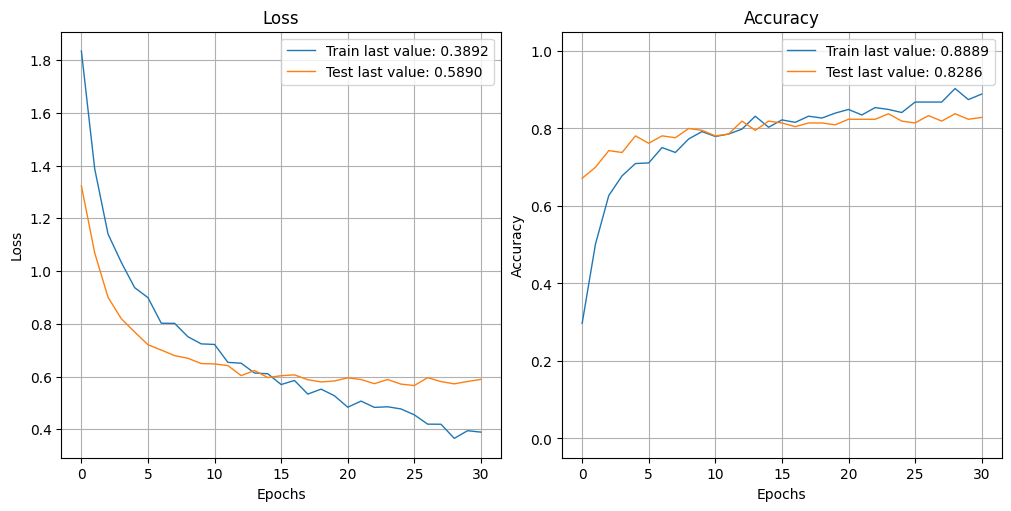

In [15]:
# Affichage de la courbe d'apprentissage de l'accuracy et de la fonction cout
show_history(history_VGG16)
plot_history(history_VGG16, path=f"../Output/Courbes_d'apprentissage/courbe_d'apprentissage_VGG16.png")
plt.close()

Lorsque la classification des produits à partir des images est réalisée avec le modèle VGG16 combiné a une augmentation des données du jeu d'entrainement on observe une diminution rapide de la fonction de coût sur les données de validation dès les premiers epochs, avant une stabilisation autour du 10ième epoch. En revanche, sur les données d'entrainement la fonction cout continue de diminuer jusqu'à la fin de l'entrainement ce qui suggère que le modèle n'avait encore complètement convergé sur ces données. L’exactitude sur l’ensemble de validation quant à elle augmente mais sa progression est plutôt peu marquée. L’écart entre les exactitudes obtenues sur les jeux de validation et d’entraînement est relativement faible, ce qui témoigne d’un bon pouvoir de généralisation du modèle.

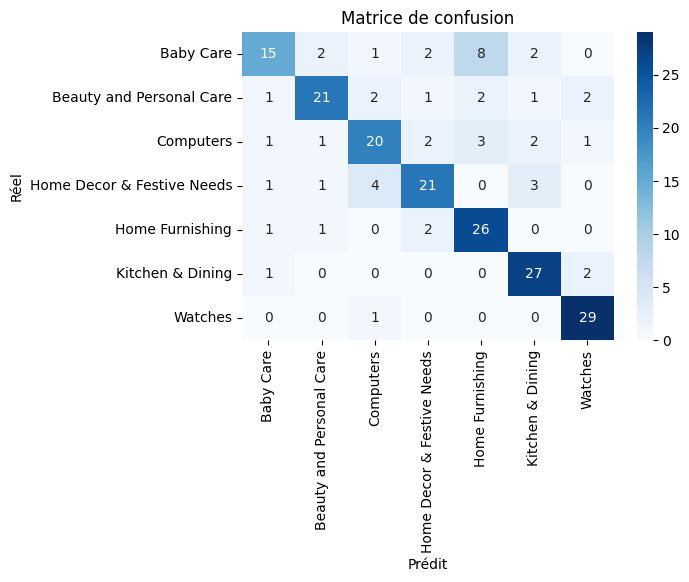

                            precision    recall  f1-score   support

                 Baby Care       0.75      0.50      0.60        30
  Beauty and Personal Care       0.81      0.70      0.75        30
                 Computers       0.71      0.67      0.69        30
Home Decor & Festive Needs       0.75      0.70      0.72        30
           Home Furnishing       0.67      0.87      0.75        30
          Kitchen & Dining       0.77      0.90      0.83        30
                   Watches       0.85      0.97      0.91        30

                  accuracy                           0.76       210
                 macro avg       0.76      0.76      0.75       210
              weighted avg       0.76      0.76      0.75       210



In [16]:
# Prédictions des probas de chaque classes pour chaque images
y_test_pred_proba = model_VGG16.predict(dataset_test, verbose=0)

# Extraction de la classe la plus probable pour chaque image
y_test_pred = np.argmax(y_test_pred_proba, axis=1) 

# Définition des labels selon l’ordre exact des classes dans y_test
labels = sorted(np.unique(np.concatenate((y_test_true, y_test_pred))))

# Matrice de confusion avec labels explicites
conf_mat = confusion_matrix(y_test_true, y_test_pred, labels=labels)

# Décodage des catégories
labels = encoder.inverse_transform(labels)

# Conversion en dataframe avec les bons labels
df_cm = pd.DataFrame(conf_mat, index=labels, columns=labels)

# Construction de la figure
plt.figure(figsize = (6,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.savefig(f'../Output/Matrice_de_confusion/Matrice_de_confusion_VGG16_1.png', format='png')
plt.show()

# Affichage du rapport de classification
print(classification_report(y_test_true, y_test_pred, target_names=labels))

La matrice de confusion ainsi que le rapport de classfication montrent que le modèle VGG16 a  obtenu une bonne performance caractérisée par une exactitude de 76% sur les données test.

Les scores observés pour la précision apparaissent relativement homogène entre les différentes catégories avec des valeurs comprises entre 71% et 85%. Les écarts observés pour les scores de rappel sont au contraire un peu plus marqués et prenent des valeurs comprises entre 50% et 97%. La catégorie Watch se démarque avec à la fois la meilleure précision et le meilleur rappel obtenu. A l'inverse les catégories Baby Care et Computer correspondent aux catégories qui présentent globalement les moins bon scores avec une précision de 75% et 71% respectivement et un rappel de 50% et 67% respectivement. Les produits appartenant réellement a la catégorie Computer ont été prédits dans chacune des autres catégories de facon équitable. Cela suggère une plus grande difficulté du modèle a identifier certaines images de cette catégorie.

En résumé, le modèle propose des performances globalement très satisfaisantes avec un bon compromis entre précision et rappel.

In [17]:
# Création de la dataframe de résultats associés au modèle VGG16
Resultats = pd.DataFrame({
    'approche': ['model_VGG16'],
    'accuracy_train': [accuracy_train_VGG16],
    'accuracy_val': [accuracy_val_VGG16],
    'accuracy_test': [accuracy_test_VGG16],
    "temps d'entraînement": [duration_VGG16]
})

# Affichage de la dataframe de résultats
Resultats

,approche,accuracy_train,accuracy_val,accuracy_test,temps d'entraînement
0,model_VGG16,0.915873,0.814286,0.757143,1237.297745


# Nouvelle approche:  CvT avec data augmentation

Le prochain modèle qui sera exploré est un CvT (Convolutional Vision Transformer) qui correspond à une architecture hybride  combinant les points forts de deux approches de deep learning: la convolution des réseaux de neurones convolutifs et les mécanismes d'attention des transformeurs. La convolution permettra de détecter efficacement des motifs locaux dans une image et l’attention permettra de relier entre elles différentes région de l’image et comprenndre leur organisation globale. 

Comme pour l'approche avec le modèle VGG16, on utilisera le transfert d'apprentissage en utilisant un modèle pré-entrainé. Le modèle sera adapté à la tache de classification automatique de produits en ajoutant une tête de classification personnalisée et adapté à cette tâche.  Pour cela, les poids du squelette du modèle CvT seront figés pour ne pas être réappris pendant l’entraînement et la dernière couche de classification sera remplacée par un petit réseau entièrement connecté comprenant une couche dense linéaire, une activation ReLU, un dropout de régularisation, puis une sortie linéaire vers le nombre de classes cibles. Le modèle sera optimisé grâce à l’optimiseur Adam appliqué uniquement aux paramètres entraînables, et la fonction de perte correspondra à la CrossEntropyLoss, adaptée aux tâches de classification multi-classes.

Une aumgmentation de données sera également ajouté ici et comprendra les même variations que celles configurées pour l'approche initiale, à savoir des flips horizontaux aléatoires, des rotations, des zooms suivis d’une normalisation. 

## Fonctions utiles

Contrairement à l'approche avec VGG16 sous Keras, où l’entraînement, l’évaluation et la prédiction sont directement pris en charge par des méthodes comme .fit(), .evaluate() et .predict(), les modèle de type PyTorch comme le CVT exploré ici ne disposent pas de ce type d'implémentation. Il sera donc nécessaire de définir des fonctions permettant de reproduire les méthode .fit(), .evaluate() et .predict().

Le développement de cette nouvelle approche de modélisation fera donc intervenir 4 fonctions
- La première fonction permettra de construire le modèle
- La deuxième fonction permettra d'entrainer le modèle qui gèrera l'itération sur les différents batch, la remise à zero des gradients, la propagation avant, le calcul de la perte, la rétropropagation et la mise à jour des poids. Elle permettra également de sauvegarder le meilleur modèle et de configurer l'arrêt prématuré du modèle. 
- La troisième fonction permettra d'évaluer les performances du modèle grâce au calcul de l'exactitude
- La quatrième fonction permettra de prédire les catégories des produits à partir d'images

In [17]:
def create_model_CVT(num_classes=7, dense_size=256, dropout=0.5, learning_rate=1e-3, freeze_backbone=True, device=None, verbose=True):
    """
    Crée un modèle CvT pour classification avec head personnalisée et renvoie aussi les transformations 
    de data augmentation pour l'entraînement et la validation.
    
    Sortie:
        model: modèle PyTorch
        optimizer: optimiseur Adam
        criterion: CrossEntropyLoss
        device: device utilisé
        train_transform: transformations pour data augmentation train
        val_transform: transformations pour validation
    """
    
    # Configuration du periphérique selon la disponibilité d'un GPU ou non
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    # -------------------------
    # Data augmentation
    # -------------------------
    
    # Définition des transformations appliquées au jeu d'entrainement
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Définition des transformations appliquées au jeu de validation
    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # -------------------------
    # Modèle CvT
    # -------------------------
    
    # Chargement du modèle CvT pré entrainé
    model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
    
    # Gel des poids déjà appris
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    # Extraction du nombre de neurones en entrée de la couche de classification
    in_features = model.classifier.in_features
    
    # Adaptation du modèle à la tache de classification des produits
    model.classifier = nn.Sequential(
        nn.Linear(in_features, dense_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(dense_size, num_classes)
    )
    
    # Déplacement du modèle sur le périphérique selectionné
    model = model.to(device)
     
    # -------------------------
    # Optimiseur et loss
    # -------------------------
    
    # Configuration de l'optimiseur
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Configuration du critère d'optimisation
    criterion = nn.CrossEntropyLoss()
    
    # Affichage d'informations
    if verbose:
        print(summary(model, input_size=(1, 3, 224, 224)))

    return model, optimizer, criterion, device, train_transform, val_transform



In [18]:
def model_training(model, optimizer, criterion, train_loader, val_loader, model_save_path,
                num_epochs=50, patience=5, device="cuda", verbose=True):

    """
    Entraîne un modèle PyTorch avec gestion de l'early stopping et suivi des métriques.

    Paramètres
        model (torch.nn.Module): Le modèle à entraîner.
        optimizer (torch.optim.Optimizer): L’optimiseur utilisé pour la mise à jour des poids.
        criterion (torch.nn.Module): La fonction de perte utilisée.
        train_loader (torch.utils.data.DataLoader): DataLoader pour les données d’entraînement.
        val_loader (torch.utils.data.DataLoader): DataLoader pour les données de validation.
        num_epochs (int, par défaut=50): Nombre maximum d’époques d’entraînement.
        patience (int, par défaut=5): Nombre d’époques consécutives sans amélioration avant arrêt anticipé (early stopping).
        device (str, par défaut="cuda"): Périphérique utilisé (CPU ou GPU).
        verbose (bool, par défaut=True): Si True, affiche les métriques à chaque époque.

    Sortie
        history (dict): dictionnaire contenant l’évolution des métriques :
        - train_loss : pertes sur le train
        - val_loss : pertes sur la validation
        - train_acc : précisions sur le train
        - val_acc : précisions sur la validation
    """
    
    # Initialisation du dictionnaire de résultat
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Initialisation de la meilleure valeur de perte et du nombre d'epoch sans amélioration
    best_val_loss = float("inf")
    epochs_no_improve = 0

    # Pour chaque epoch
    for epoch in range(num_epochs):
        
        
        # Entrainement
        #---------------------------------------------------------------------------------
        
        # Passage du modèle en mode entrainement
        model.train()
        
        # Pour chaque bactch
        for imgs, labels in train_loader:
            
            # Déplacement des images et labels sur le périphérique
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Remise à 0 des gradients
            optimizer.zero_grad()
            
            # Prédiction
            outputs = model(pixel_values=imgs).logits
            
            # Calcul de la perte
            loss = criterion(outputs, labels)
            
            # Rétropropagation
            loss.backward()
            optimizer.step()
            
        # Evaluation sur le jeu d'entrainement
        #--------------------------------------------------------------------------------------
     
        # Passage du modèle en mode évaluation
        model.eval()
        
        # Initialisation des scores
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        # Désactivation des gradients et calculs préliminaires
        with torch.no_grad():
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(pixel_values=imgs).logits
                loss = criterion(outputs, labels)
                train_loss += loss.item() * imgs.size(0)
                _, predicted = outputs.max(1)
                train_correct += predicted.eq(labels).sum().item()
                train_total += labels.size(0)
           
        # Calcul de la perte et de l'exactitude sur l'ensemble des données
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Evaluation sur le jeu de validation
        #--------------------------------------------------------------------------------------
        
        # Initialisation des scores
        val_loss, val_correct, val_total = 0.0, 0, 0

        # Désactivation des gradients et calculs préliminaires
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(pixel_values=imgs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        # Calcul de la perte et de l'exactitude sur l'ensemble des données
        val_loss /= val_total
        val_acc = val_correct / val_total
        

        # Stockage des résultats
        #--------------------------------------------------------------------------------------
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Affichage des informations si demandé
        #--------------------------------------------------------------------------------------

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Arrêt anticipé de l'entrainement si pas d'amélioration
        #--------------------------------------------------------------------------------------

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            if verbose:
                print(f"Validation loss decreased, saving model to {model_save_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print("Early stopping triggered!")
                break

    return history


In [19]:
def evaluate_model(model, dataloader, device):
    """
    Évalue la précision d'un modèle de type PyTorch sur un jeu de données.

    Paramètres:
        - model (torch.nn.Module): Le modèle PyTorch à évaluer.
        - dataloader (torch.utils.data.DataLoader): DataLoader contenant les images et labels pour l'évaluation.
        - device (torch.device): Le périphérique sur lequel exécuter le modèle (ex: 'cpu' ou 'cuda').

    Sortie:
        float: La précision (accuracy) du modèle sur l'ensemble des données fournies, sous forme d'un nombre compris entre 0 et 1.

    """
    
    # Passage du modèle en mode évaluation
    model.eval()
    
    # Initialisation des listes de résultats
    all_preds = []
    all_labels = []
    
    # Supression des gradients
    with torch.no_grad():
        
        # Boucle sur les images
        for imgs, labels in dataloader:
            
            # Déplacement des donnée sur le bon periphérique
            imgs, labels = imgs.to(device), labels.to(device)
            
            # calcul des sorties du modèle
            outputs = model(pixel_values=imgs).logits
           
            # Prédiction de la classe
            _, predicted = outputs.max(1)
            
            # Mise à jour des compteurs
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcul de l'accuracy
    acc = accuracy_score(all_preds, all_labels)
    
    return acc


In [20]:
def predict_model(model, dataloader, device):
    
    """"
    Effectue une prédiction avec un modèle PyTorch sur un jeu de données donné.

    Paramètres
        model (torch.nn.Module): Le modèle entraîné 
        dataloader (torch.utils.data.DataLoader): Le DataLoader contenant les images (inputs) et leurs labels.
        device (torch.device): Le périphérique utilisé pour l’inférence (CPU ou GPU).

    Sortie
        all_probs (np.ndarray): Tableau contenant les probabilités prédites pour chaque classe.
        preds (np.ndarray): Tableau contenant les classes prédites (argmax des probabilités).
        all_labels (np.ndarray): Tableau contenant les labels réels (ground truth).
    """
    
    # Passage du modèle en mode évaluation
    model.eval()
    
    # Initialisation des listes de résultats
    all_probs = []
    all_labels = []
    
    # Désactivation de la rétropropagation
    with torch.no_grad():
        
        # Pour chaque batch
        for imgs, labels in dataloader:
            
            # Déplacement des images sur le périphérique
            imgs = imgs.to(device)
            
            # Extraction des logits après passage des images dans le modèle
            outputs = model(pixel_values=imgs).logits
            
            # Transformation des logit en probabilité
            probs = torch.softmax(outputs, dim=1) 
            
            # Ajout des résultats
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concaténation des différents batch
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Calcul de la classe prédite
    preds = np.argmax(all_probs, axis=1)
    
    return all_probs, preds, all_labels

## Entrainement et évaluation

In [21]:
# Définition du chemin de sauvegarde
model_CVT_save_path = f"../Models/CVT/model_CVT_best_weights_{date_str}.pth"

# Définition des paramètres
patience = 5           
num_epochs = 50         
batch_size = 32

# Création du modèle
device = "cuda" if torch.cuda.is_available() else "cpu"
model_CVT, optimizer, criterion, device, train_transform, val_transform = create_model_CVT()

#  Définitions des dataset
train_dataset = ImageFolder("../Data/Image_train/", transform=train_transform)
val_dataset   = ImageFolder("../Data/Image_val/",   transform=val_transform)
test_dataset   = ImageFolder("../Data/Image_test/",   transform=val_transform)

# Chargement des images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Layer (type:depth-idx)                                                                     Output Shape              Param #
CvtForImageClassification                                                                  [1, 7]                    --
├─CvtModel: 1-1                                                                            [1, 1, 384]               --
│    └─CvtEncoder: 2-1                                                                     [1, 1, 384]               --
│    │    └─ModuleList: 3-1                                                                --                        (19,611,712)
├─LayerNorm: 1-2                                                                           [1, 1, 384]               (768)
├─Sequential: 1-3                                                                          [1, 7]                    --
│    └─Linear: 2-2                                                                         [1, 256]                  98,560
│    └─ReLU: 2-3  

In [23]:
# Définition du temps avant l'entrainement du modèle
start_CVT = time.time()

# Entrainement du modèle
history_CVT = model_training(model_CVT, optimizer, criterion, train_loader, val_loader, 
                             model_CVT_save_path, num_epochs=50, device=device)

# Calcul du temps d'execution de l'entrainement du modèle
duration_CVT  = time.time() - start_CVT

Epoch 1/50 | Train Loss: 1.1149, Acc: 0.8587 | Val Loss: 1.1337, Acc: 0.8238
Validation loss decreased, saving model to ../models/classification/model_CVT_best_weights2025-09-24_23-15-58.pth
Epoch 2/50 | Train Loss: 0.6233, Acc: 0.8714 | Val Loss: 0.6733, Acc: 0.8381
Validation loss decreased, saving model to ../models/classification/model_CVT_best_weights2025-09-24_23-15-58.pth
Epoch 3/50 | Train Loss: 0.4368, Acc: 0.8984 | Val Loss: 0.5291, Acc: 0.8429
Validation loss decreased, saving model to ../models/classification/model_CVT_best_weights2025-09-24_23-15-58.pth
Epoch 4/50 | Train Loss: 0.3569, Acc: 0.9127 | Val Loss: 0.4849, Acc: 0.8524
Validation loss decreased, saving model to ../models/classification/model_CVT_best_weights2025-09-24_23-15-58.pth
Epoch 5/50 | Train Loss: 0.2950, Acc: 0.9317 | Val Loss: 0.4574, Acc: 0.8429
Validation loss decreased, saving model to ../models/classification/model_CVT_best_weights2025-09-24_23-15-58.pth
Epoch 6/50 | Train Loss: 0.2493, Acc: 0.9317 

In [24]:
# Calcul de l'accuracy sur les données d'entrainement
train_acc = evaluate_model(model_CVT, train_loader, device)

# Calcul de l'accuracy sur les données de validation
val_acc = evaluate_model(model_CVT, val_loader, device)

# Calcul de l'accuracy sur les données de test
test_acc = evaluate_model(model_CVT, test_loader, device)

# Affichage des scores d'accuracy sur le dernier epoch
print("Score d'accuracy sur le dernier epoch")
print("---------------------------------------")
print("Training Accuracy:    {:.4f}".format(train_acc))
print("Validation Accuracy:  {:.4f}".format(val_acc))
print("Test Accuracy:  {:.4f}".format(test_acc))


Score d'accuracy sur le dernier epoch
---------------------------------------
Training Accuracy:    0.9778
Validation Accuracy:  0.8571
Test Accuracy:  0.8857


À la fin  de l'entrainement, le modèle présente une exactitude de **97.78 %** sur l’ensemble d’entraînement, ce qui indique un excellent apprentissage des données. L’exactitude sur l’ensemble de validation est de **85,71 %** et augmente légèrement sur le jeu de test avec une valeur de **88,57 %**.

In [25]:
# Chargement du modèle CVT
model_CVT.load_state_dict(torch.load(f"../Models/CVT/model_CVT_best_weights_{date_str}.pth", map_location=device))

<All keys matched successfully>

In [26]:
# Calcul de l'accuracy sur les données d'entrainement
train_acc = evaluate_model(model_CVT, train_loader, device)

# Calcul de l'accuracy sur les données de validation
val_acc = evaluate_model(model_CVT, val_loader, device)

# Calcul de l'accuracy sur les données de test
test_acc = evaluate_model(model_CVT, test_loader, device)

# Calcul et affichage des scores d'accuracy sur l'epoch optimal
print("Score d'accuracy sur le dernier epoch")
print("---------------------------------------")
print("Training Accuracy:    {:.4f}".format(train_acc))
print("Validation Accuracy:  {:.4f}".format(val_acc))
print("Test Accuracy:  {:.4f}".format(test_acc))


Score d'accuracy sur le dernier epoch
---------------------------------------
Training Accuracy:    0.9587
Validation Accuracy:  0.8619
Test Accuracy:  0.8762


À l’epoch optimal, le modèle présente une exactitude de **95.87 %** sur l’ensemble d’entraînement, ce qui indique un bon apprentissage des données. L’exactitude sur l’ensemble de validation est de **86,19 %** et est similaire sur le jeu de test avec une valeur de **87.62 %** sur le jeu de test. En comparaison avec la première approche, on note ici un écart plus important entre l'exactitude mesurée à l'entrainement et celle mesurée en validation ce qui suggère un sur apprentissage un peu plus marquée avec le modèle CvT. 

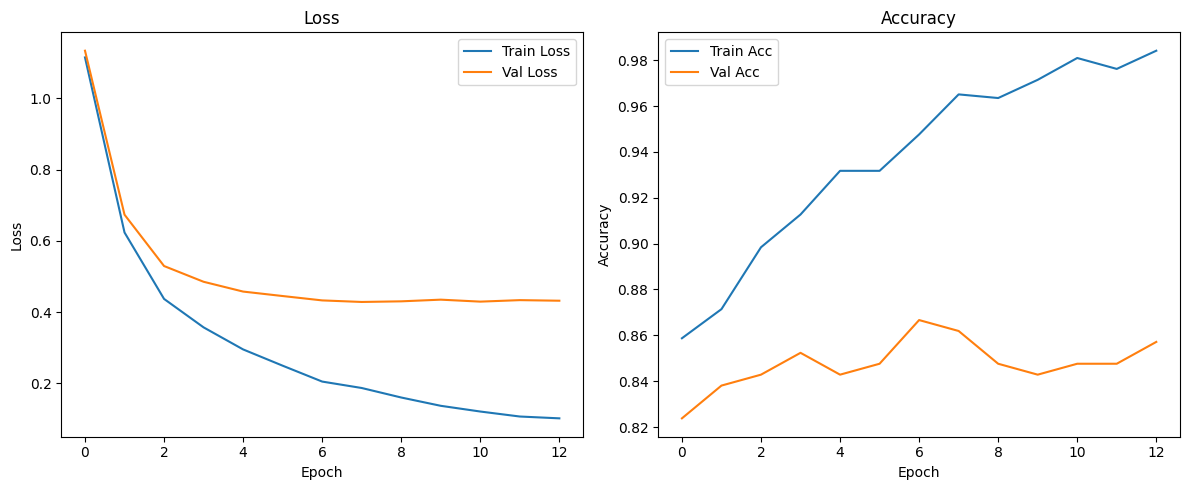

In [27]:
# Initialisation de la figure
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_CVT['train_loss'], label='Train Loss')
plt.plot(history_CVT['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_CVT['train_acc'], label='Train Acc')
plt.plot(history_CVT['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"../Output/Courbes_d'apprentissage/Courbe_d'apprentissage_CVT_{date_str}.png")
plt.show()


Lorsque la classification des produits à partir des images est réalisée avec le modèle CvT combiné a une augmentation des données on observe une diminution de la fonction de coût sur les données de d'entrainement et de validation dès les premiers epochs, avant une stabilisation autour du 4e epoch sur les données de validation. La fonction cout mesurée sur les données d'entrainement continue de diminuer sur les derniers epochs ce qui suggère que le modèle avait encore une marge de progression sur les données d'entrainement. L’exactitude sur l’ensemble de validation quant à elle augmente mais sa progression est plutôt peu marquée et instable. L’écart entre les exactitude obtenues sur les jeux de validation et d’entraînement est plus marqué que pour le modèle VGG16.

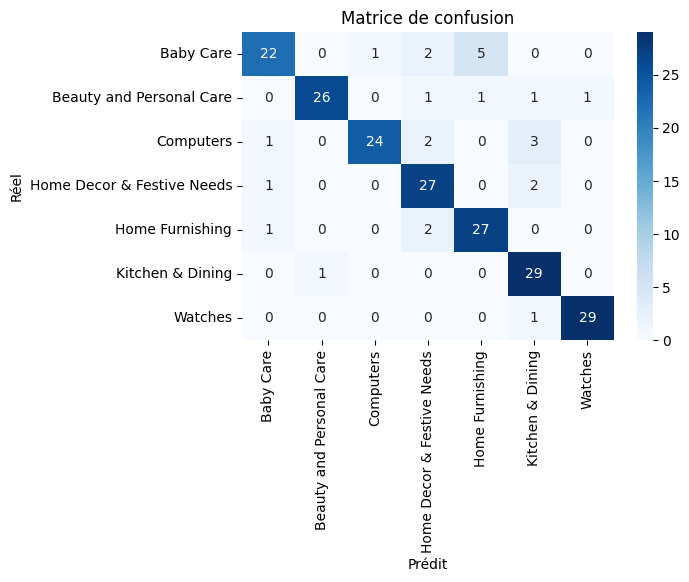

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.73      0.80        30
  Beauty and Personal Care       0.96      0.87      0.91        30
                 Computers       0.96      0.80      0.87        30
Home Decor & Festive Needs       0.79      0.90      0.84        30
           Home Furnishing       0.82      0.90      0.86        30
          Kitchen & Dining       0.81      0.97      0.88        30
                   Watches       0.97      0.97      0.97        30

                  accuracy                           0.88       210
                 macro avg       0.88      0.88      0.88       210
              weighted avg       0.88      0.88      0.88       210



In [28]:
# Prédictions
y_test_pred_proba, y_test_pred, y_test_true = predict_model(model_CVT, test_loader, device)

# Labels (indices de classes)
labels = sorted(np.unique(np.concatenate((y_test_true, y_test_pred))))

# Matrice de confusion
conf_mat = confusion_matrix(y_test_true, y_test_pred, labels=labels)

# Si tu as un encoder (classes -> labels texte)
labels_decoded = encoder.inverse_transform(labels)

# Dataframe pour affichage
df_cm = pd.DataFrame(conf_mat, index=labels_decoded, columns=labels_decoded)

# Construction de la figure
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.savefig(f'../Output/Matrice_de_confusion/Matrice_de_confusion_CVT.png', format='png')
plt.show()

# Rapport de classification
print(classification_report(y_test_true, y_test_pred, target_names=labels_decoded))


Le modèle CvT atteint une exactitude globale de 88 % sur l’ensemble du jeu de test, soit une amélioration notable par rapport aux résultats précédents (76 %). Les scores de rappel et de precision sont globalement plus élevés et homogènes, avec des score de précisions et de rappel compris entre 76% et 97% et 77% et 97% respectivement.

Les catégories Watches et Kitchen & Dining obtiennent à nouveau des scores particulièrement élevés, avec un rappel supérieur à 95 %, traduisant une excellente capacité du modèle à identifier correctement ces classes. Les classes Beauty and Personal Care  et Computers  montrent également de très bonnes performances, combinant précision élevée et rappel satisfaisant.
Les performaces associées aux catégories Baby Care, Home Decor & Festive Needs, et Home Furnishing sont légèrement inférieures mais restent néanmoins très satisfaisantes.

En comparaison avec le modèle VGG16 (76 % d'exactitude), le modèle CvT présente donc un gain d’environ 12 points d’exactitude, ainsi qu’une nette progression de la performance sur la majorité des classes, en particulier pour la catégorie Home Decor et Beauty and Personnal care. Cette amélioration suggère que la combinaison de la convolution et des mécanismes d'attention permet une meilleure généralisation et une réduction des erreurs de classification.

In [29]:
# Création de la dataframe de résultats associés au modèle CvT
Resultats_CVT = pd.DataFrame({
    'approche': ['model_CVT'],
    'accuracy_train': [train_acc],
    'accuracy_val': [val_acc],
    'accuracy_test': [test_acc],
    "temps d'entraînement": [duration_CVT]
})

# Ajout des résultats du modèle CvT à la table de résultats
Resultats = pd.concat([Resultats, Resultats_CVT])

# Affichage de la table de résultats
Resultats

,approche,accuracy_train,accuracy_val,accuracy_test,temps d'entraînement
0,model_VGG16,0.915873,0.814286,0.757143,1237.297745
0,model_CVT,0.958730,0.861905,0.876190,1066.105877


# Comparaison des deux approches


In [30]:
def plot_resultats_modeles(df_resultats, ordre_score_approche, dict_couleurs, save_name):
    """
    Génère un barplot comparant les performances de plusieurs approches de modèles
    en termes d'accuracy (train, validation, test) et de temps d'entraînement.

    Paramètres
        df_resultats (pandas.DataFrame): Dataframe contenant les résultats des modèles avec au minimum les colonnes:
                - approche: nom de l'approche de modélisation
                - accuracy_train, accuracy_val, accuracy_test: scores d'accuracy
                - temps d'entraînement: durée d'entraînement du modèle
        ordre_score_approche (list of str): Liste ordonnée des combinaisons Score_Approche à utiliser pour organiser les barres dans le barplot.
        dict_couleurs (dict): Dictionnaire associant une couleur à chaque Score_Approche.
        save_name (str): Nom de sauvegarde de la figure

    Retour
        p (plotnine.ggplot): barplot construit
    """
    
    # Reformatage de la table de résultat en format long
    resultats_pivot = pd.melt(
        df_resultats,
        id_vars='approche',
        value_vars=['accuracy_train', 'accuracy_val', 'accuracy_test', "temps d'entraînement"],
        var_name='Score',
        value_name='Value')

    # Ajout d'une colonne pour distinguer les types de métriques
    resultats_pivot['Metric'] = resultats_pivot['Score'].apply(
        lambda x: 'Accuracy' if 'accuracy' in x else 'Temps')

    # Simplification des noms pour affichage
    resultats_pivot['Score'] = resultats_pivot['Score'].replace({
        'accuracy_train': 'Train',
        'accuracy_val': 'Validation',
        'accuracy_test': 'Test',
        "temps d'entraînement": "Temps d'entraînement"})

    # Création d'une variable qui sera utilisée pour colorer les barres du barplot
    resultats_pivot['Score_Approche'] = resultats_pivot.apply(
        lambda row: f"{row['Score']}_{row['approche']}", axis=1)

    # Conversion de la variable Score Approche en variable catégorielle
    resultats_pivot['Score_Approche'] = pd.Categorical(
        resultats_pivot['Score_Approche'],
        categories=ordre_score_approche,
        ordered=True)

    # Création de la colonne label
    resultats_pivot['label'] = resultats_pivot['Score'].map({
        'Train': 'Train',
        'Validation': 'Val',
        'Test': 'Test'})

    # Création d'un dataframe qui sera utilisé pour ajouter un label en dessous des barres d'accuracy du barplot
    df_labels = resultats_pivot[resultats_pivot['Metric'] == 'Accuracy'].copy()
    
    # Calcul de la position y pour les labels
    df_labels['y_label'] = -0.05

    # Construction du graphique
    p = (
        ggplot(resultats_pivot, aes(x='approche', y='Value', fill='Score_Approche')) +
        geom_bar(stat='identity', position='dodge') +
        geom_text(
            data=df_labels,
            mapping=aes(x='approche', y='y_label', label='label', group='Score_Approche'),
            position=position_dodge(width=0.9),
            size=10
        ) +
        facet_wrap('~Metric', ncol=1, scales='free_y') +
        scale_fill_manual(values=dict_couleurs) +
        theme(
            figure_size=(12, 8),
            strip_text=element_text(size=12, weight='bold'),
            legend_position='none'
        ) +
        labs(
            y='Valeur',
            x='Approche',
            title='Performance des modèles : accuracy, temps'
        )
    )
    
    p.save(f"../Output/Comparaison_modèles/{save_name}", dpi=300)

    
    return p


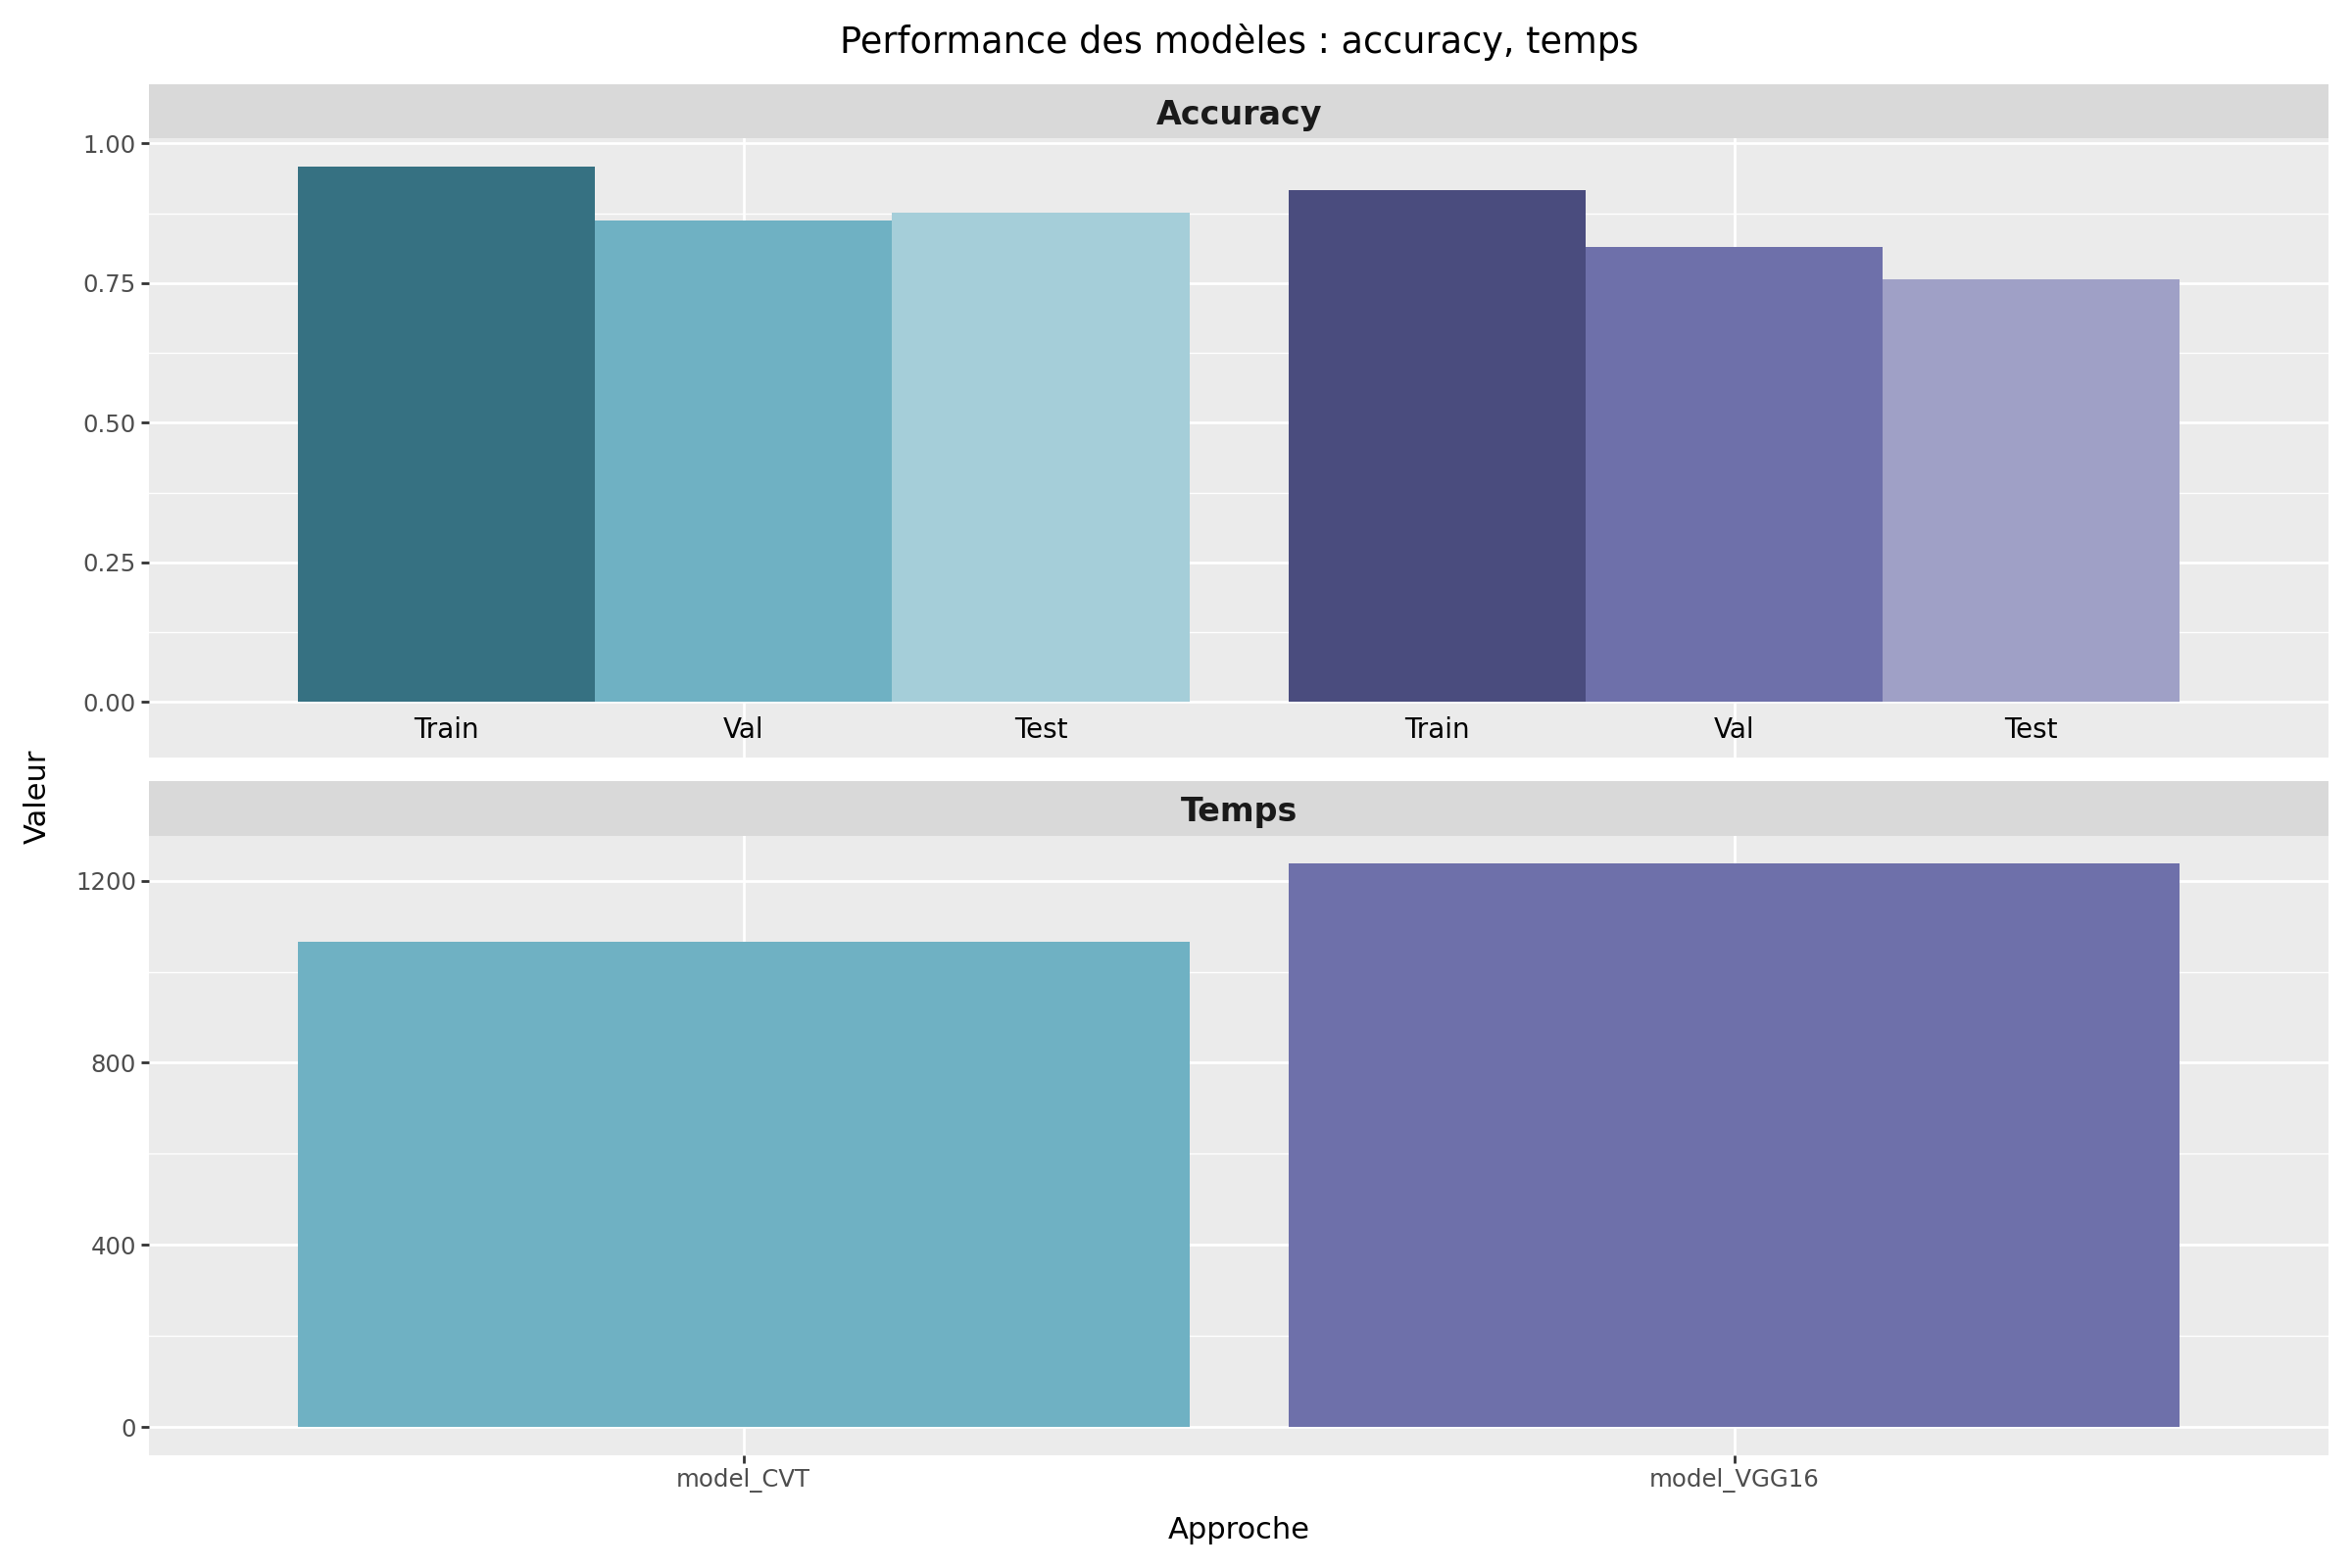

In [31]:
import warnings
from plotnine.exceptions import PlotnineWarning

warnings.filterwarnings("ignore", category=PlotnineWarning)

# Définition d'un dictionnaire de correspondance de couleur
custom_colors = {
    # Accuracy 
    'Train_model_VGG16': '#4a4c7e',  'Validation_model_VGG16': '#6e70aa', 'Test_model_VGG16': '#9fa0c6',  
    'Train_model_CVT': '#367182','Validation_model_CVT': '#6fb1c3','Test_model_CVT': '#a5ced9',

    # Temps d'entraînement 
    "Temps d'entraînement_model_VGG16": '#6e70aa',
    "Temps d'entraînement_model_CVT": '#6fb1c3'}

# Détermination de l'ordre d'apparition des bar dans le barplot
ordre = [
    'Train_model_VGG16', 'Validation_model_VGG16', 'Test_model_VGG16',
    'Train_model_CVT', 'Validation_model_CVT', 'Test_model_CVT',
    "Temps d'entraînement_model_VGG16", "Temps d'entraînement_model_CVT"
]

# Appel de la fonction
plot_resultats_modeles(df_resultats=Resultats, ordre_score_approche=ordre, dict_couleurs=custom_colors, save_name="Comparaison_modèles")

Comme discuté précédemment le modèle CvT a abouti a des performances supérieures à celles obtenues avec le modèle VGG16. Les score d'exactitude sont meilleurs sur les trois sous ensemble de données évalués. En plus de cette amélioration des résultats, on observe également une légère réduction du temps d'entrainement du modèle ce qui renforce l'intérêt pratique de cette architecture.

Il serait intéressant d'aller plus loin en optmisant ce modèle en ajustant certains hyperparamètres, comme le nombre de neurones dans la couche dense entrainable, le taux d'apprentissage ou encore le pourcentage de neurones à supprimer lors de la phase de dropout, afin de voir s'il est possible d'améliorer ses performances.

# Optimisation du modèle CvT

Pour améliorer les performances du modèle CvT, les paramètres de celui ci vont être optimisés à l'aide d'Optuna, une bibliothèque spécialisée dans la recherche automatique et intelligente des meilleurs paramètres pour les modèles de machine learning.

L’idée est de tester différentes configurations du modèle afin de trouver celles qui minimisent la fonction cout sur les données de validation. Parmi les hyperparamètres qu'il serait intéressant d'optimiser on retrouve :
- la taille de la couche dense (dense_size) de la tête de classification,
- le taux de dropout pour régulariser le modèle et éviter le surapprentissage,
- le learning rate de l’optimiseur Adam,
- la possibilité de geler ou non le squelette pré-entraîné du CvT (freeze_backbone).

Pour mettre cela en place une fonction sera définie et permettra d'enchainer les étapes suivantes: pour chaque essaie, proposition d'une combinaison de paramètres par optuna, création du modèle CvT correspondant, et entrainement du modèle. Après l’entraînement, le modèle pourra être évalué sur les ensembles d'entrainement, de validation et de test, et les métriques (accuracy, temps d’entraînement) seront enregistrées.

L’algorithme d’Optuna utilise les résultats obtenus à un essai pour guider les essais suivants, en privilégiant les combinaisons prometteuses et en explorant intelligemment l’espace des hyperparamètres. À la fin, on obtient la configuration qui offre les meilleures performances sur les données de validation, ce qui permet de maximiser la généralisation du modèle.

In [32]:
def objective(trial):
    
    """
    Fonction objectif pour l'optimisation avec Optuna.
    
    Cette fonction définie l'espace de recherche des hyperparamètres, 
    construit et entraine un modèle CvT de classification, puis retourne la meilleure
    valeur de perte sur les données de validation obtenue. Les métriques de performances associées aux données
    d'entrainement, de validation et de test ainsi que le temps d'entrainement sont sauvegardés
    dans les attribus de l'objet trial
    
    Paramètres
        trial (optuna.trial): essai Optuna
    
    Sortie
        La meilleure accuracy sur les données de validation atteinte durant l'entrainement
    """
    
    # Hyperparamètres à tester
    dense_size = trial.suggest_categorical("dense_size", [128, 256, 512])
    dropout = trial.suggest_float("dropout", 0.3, 0.7)
    learning_rate   = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  
    freeze_backbone = trial.suggest_categorical("freeze_backbone", [True, False])
    
    # Affichages des valeurs des paramètres testés
    print(f"Trial: {trial.number}, dense_size: {dense_size}, dropout: {dropout:.4f}, learning_rate: {learning_rate:.4f}, freeze_backbone: {freeze_backbone}")

    # Configuration du periphérique selon la disponibilité d'un GPU ou non
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Création du modèle
    model, optimizer, criterion, device, train_tf, val_tf = create_model_CVT(
        num_classes=7,
        dense_size=dense_size,
        dropout=dropout,
        learning_rate=learning_rate,
        freeze_backbone=freeze_backbone,
        device=device, verbose=False
    )
    
    # Initialisation du temps
    start = time.time()

    # save path
    Save_path =  f"../Models/Optimisation/model_CVT_best_weights_trial_{trial.number}_{date_str}.pth"

    # Entraînement du modèle 
    history = model_training(
        model, optimizer, criterion,
        train_loader, val_loader,
        Save_path,
        num_epochs=50, 
        patience=5,
        device=device, verbose=False
    )
    
    # Calcul de la durée d'entrainement
    duration = time.time() - start
    
    # Chargement du meilleur modèle obtenu avant l'early stoping
    model.load_state_dict(torch.load(Save_path, map_location=device))

    # Cacul de l'accuracy des modèles
    train_metrics = evaluate_model(model, train_loader, device)
    val_metrics  = evaluate_model(model, val_loader, device)
    test_metrics  = evaluate_model(model, test_loader, device)

    # Ajout des résultats dans l'étude
    trial.set_user_attr("accuracy_train", train_metrics)
    trial.set_user_attr("accuracy_val", val_metrics)
    trial.set_user_attr("accuracy_test", test_metrics)
    trial.set_user_attr("temps d'entraînement", duration)

    return min(history["val_loss"])


In [33]:
print("---------------------------------------------------------------")
print("Optimisation du model CvT")
print("---------------------------------------------------------------")

# Initialisation de l'étude optuna
study = optuna.create_study(direction="minimize")

# Optimisation de l'étude optuna
study.optimize(objective, n_trials=20) 

# Affichage des meilleurs paramètres et de la meilleur accuracy en validation
print("Best params:", study.best_params)
print("Best val accuracy:", study.best_value)

#Sauvegarde des résultats
joblib.dump(study, f"../Output/Optuna/optuna_results_{date_str}.joblib")


[I 2025-09-25 09:12:10,116] A new study created in memory with name: no-name-0a9acf67-58b9-4c71-ba3b-72f1f9430c63


---------------------------------------------------------------
Optimisation du model CvT
---------------------------------------------------------------
Trial: 0, dense_size: 512, dropout: 0.5073, learning_rate: 0.0007, freeze_backbone: False


[I 2025-09-25 09:54:47,486] Trial 0 finished with value: 0.7653121128323532 and parameters: {'dense_size': 512, 'dropout': 0.5072551117134392, 'learning_rate': 0.0007454795396098119, 'freeze_backbone': False}. Best is trial 0 with value: 0.7653121128323532.


Trial: 1, dense_size: 256, dropout: 0.3712, learning_rate: 0.0011, freeze_backbone: False


[I 2025-09-25 10:34:13,714] Trial 1 finished with value: 0.8360264091264634 and parameters: {'dense_size': 256, 'dropout': 0.37120905528789067, 'learning_rate': 0.0010520857104143375, 'freeze_backbone': False}. Best is trial 0 with value: 0.7653121128323532.


Trial: 2, dense_size: 128, dropout: 0.4627, learning_rate: 0.0004, freeze_backbone: False


[I 2025-09-25 11:09:22,673] Trial 2 finished with value: 0.5883190314329806 and parameters: {'dense_size': 128, 'dropout': 0.46274900900813076, 'learning_rate': 0.00043976126944117493, 'freeze_backbone': False}. Best is trial 2 with value: 0.5883190314329806.


Trial: 3, dense_size: 256, dropout: 0.5484, learning_rate: 0.0015, freeze_backbone: True


[I 2025-09-25 11:37:15,071] Trial 3 finished with value: 0.4368008503246875 and parameters: {'dense_size': 256, 'dropout': 0.5484150299398325, 'learning_rate': 0.001490001281397912, 'freeze_backbone': True}. Best is trial 3 with value: 0.4368008503246875.


Trial: 4, dense_size: 512, dropout: 0.4367, learning_rate: 0.0007, freeze_backbone: False


[I 2025-09-25 12:24:00,784] Trial 4 finished with value: 0.5914262628182769 and parameters: {'dense_size': 512, 'dropout': 0.43665295474258053, 'learning_rate': 0.000683139997436924, 'freeze_backbone': False}. Best is trial 3 with value: 0.4368008503246875.


Trial: 5, dense_size: 512, dropout: 0.3989, learning_rate: 0.0054, freeze_backbone: False


[I 2025-09-25 13:06:23,042] Trial 5 finished with value: 1.9214546294439407 and parameters: {'dense_size': 512, 'dropout': 0.3988965220795679, 'learning_rate': 0.005386744964658891, 'freeze_backbone': False}. Best is trial 3 with value: 0.4368008503246875.


Trial: 6, dense_size: 512, dropout: 0.3061, learning_rate: 0.0074, freeze_backbone: False


[I 2025-09-25 14:43:57,943] Trial 6 finished with value: 1.9459208374931698 and parameters: {'dense_size': 512, 'dropout': 0.3060718791938792, 'learning_rate': 0.007375462897444232, 'freeze_backbone': False}. Best is trial 3 with value: 0.4368008503246875.


Trial: 7, dense_size: 128, dropout: 0.4499, learning_rate: 0.0006, freeze_backbone: False


[I 2025-09-25 15:18:30,693] Trial 7 finished with value: 0.6553113904737291 and parameters: {'dense_size': 128, 'dropout': 0.44993101857241324, 'learning_rate': 0.0005766876316903099, 'freeze_backbone': False}. Best is trial 3 with value: 0.4368008503246875.


Trial: 8, dense_size: 256, dropout: 0.6727, learning_rate: 0.0052, freeze_backbone: True


[I 2025-09-25 15:41:11,087] Trial 8 finished with value: 0.4701971158983984 and parameters: {'dense_size': 256, 'dropout': 0.6727218128341044, 'learning_rate': 0.0052297025455042565, 'freeze_backbone': True}. Best is trial 3 with value: 0.4368008503246875.


Trial: 9, dense_size: 128, dropout: 0.5398, learning_rate: 0.0002, freeze_backbone: False


[I 2025-09-25 16:28:15,534] Trial 9 finished with value: 0.5149678932768958 and parameters: {'dense_size': 128, 'dropout': 0.5398477052202306, 'learning_rate': 0.00018331524004177352, 'freeze_backbone': False}. Best is trial 3 with value: 0.4368008503246875.


Trial: 10, dense_size: 256, dropout: 0.6029, learning_rate: 0.0020, freeze_backbone: True


[I 2025-09-25 17:02:01,696] Trial 10 finished with value: 0.4255030746349976 and parameters: {'dense_size': 256, 'dropout': 0.6029477815884313, 'learning_rate': 0.002045510846821514, 'freeze_backbone': True}. Best is trial 10 with value: 0.4255030746349976.


Trial: 11, dense_size: 256, dropout: 0.6045, learning_rate: 0.0021, freeze_backbone: True


[I 2025-09-25 17:40:49,134] Trial 11 finished with value: 0.42770827980268566 and parameters: {'dense_size': 256, 'dropout': 0.6044692711156539, 'learning_rate': 0.0021247966020152527, 'freeze_backbone': True}. Best is trial 10 with value: 0.4255030746349976.


Trial: 12, dense_size: 256, dropout: 0.6305, learning_rate: 0.0024, freeze_backbone: True


[I 2025-09-25 18:06:14,675] Trial 12 finished with value: 0.41727617312045323 and parameters: {'dense_size': 256, 'dropout': 0.6305299034196555, 'learning_rate': 0.002425228450729228, 'freeze_backbone': True}. Best is trial 12 with value: 0.41727617312045323.


Trial: 13, dense_size: 256, dropout: 0.6823, learning_rate: 0.0028, freeze_backbone: True


[I 2025-09-25 18:39:29,496] Trial 13 finished with value: 0.43527316188861037 and parameters: {'dense_size': 256, 'dropout': 0.6823275796614392, 'learning_rate': 0.002841525088084414, 'freeze_backbone': True}. Best is trial 12 with value: 0.41727617312045323.


Trial: 14, dense_size: 256, dropout: 0.6149, learning_rate: 0.0031, freeze_backbone: True


[I 2025-09-25 19:04:57,998] Trial 14 finished with value: 0.4392811221602772 and parameters: {'dense_size': 256, 'dropout': 0.6148648150539593, 'learning_rate': 0.003145644777944001, 'freeze_backbone': True}. Best is trial 12 with value: 0.41727617312045323.


Trial: 15, dense_size: 256, dropout: 0.6110, learning_rate: 0.0002, freeze_backbone: True


[I 2025-09-25 21:05:39,094] Trial 15 finished with value: 0.41405924707651137 and parameters: {'dense_size': 256, 'dropout': 0.6110118613182624, 'learning_rate': 0.00023055472822620864, 'freeze_backbone': True}. Best is trial 15 with value: 0.41405924707651137.


Trial: 16, dense_size: 256, dropout: 0.6573, learning_rate: 0.0001, freeze_backbone: True


[I 2025-09-25 22:15:58,466] Trial 16 finished with value: 0.43348357060125897 and parameters: {'dense_size': 256, 'dropout': 0.6572604711989317, 'learning_rate': 0.00014757583547835967, 'freeze_backbone': True}. Best is trial 15 with value: 0.41405924707651137.


Trial: 17, dense_size: 256, dropout: 0.5737, learning_rate: 0.0003, freeze_backbone: True


[I 2025-09-25 23:07:38,643] Trial 17 finished with value: 0.4217365956288718 and parameters: {'dense_size': 256, 'dropout': 0.573710467130405, 'learning_rate': 0.0002829736189296011, 'freeze_backbone': True}. Best is trial 15 with value: 0.41405924707651137.


Trial: 18, dense_size: 256, dropout: 0.6411, learning_rate: 0.0003, freeze_backbone: True


[I 2025-09-26 00:01:56,668] Trial 18 finished with value: 0.42526172428791015 and parameters: {'dense_size': 256, 'dropout': 0.6411184286506958, 'learning_rate': 0.00029130321677719003, 'freeze_backbone': True}. Best is trial 15 with value: 0.41405924707651137.


Trial: 19, dense_size: 128, dropout: 0.6967, learning_rate: 0.0001, freeze_backbone: True


[I 2025-09-26 01:09:47,101] Trial 19 finished with value: 0.5262851371651605 and parameters: {'dense_size': 128, 'dropout': 0.6966819483466633, 'learning_rate': 0.00010085279248317758, 'freeze_backbone': True}. Best is trial 15 with value: 0.41405924707651137.


Best params: {'dense_size': 256, 'dropout': 0.6110118613182624, 'learning_rate': 0.00023055472822620864, 'freeze_backbone': True}
Best val accuracy: 0.41405924707651137


['../Output/Optuna/optuna_results_2025-09-24_23-15-58.joblib']

In [34]:
# Chargement de la table de résultats
study=joblib.load(f"../Output/Optuna/optuna_results_{date_str}.joblib")

In [35]:
# Construction d'une tableau de données résumant l'optimisation
trials_df = pd.DataFrame([{
    "trial": t.number,
    "value": t.value,
    **t.params,
    **{k: t.user_attrs.get(k) for k in ["accuracy_train","accuracy_val","accuracy_test", "temps d'entraînement"]}
} for t in study.trials])


# Ajout d'une variable indique le nom de l'approche
trials_df["approche"] = "Model_CvT_" + trials_df["trial"].astype(str)

# Sauvegarde de la table de résultats 
trials_df.to_csv(f"../Output/Table/optimisaiton_df_{date_str}.csv", index=False)

# Affichage de la table de résultats
trials_df

,trial,value,dense_size,dropout,learning_rate,freeze_backbone,accuracy_train,accuracy_val,accuracy_test,temps d'entraînement,approche
0,0,0.765312,512,0.507255,0.000745,False,0.955556,0.766667,0.771429,2450.449256,Model_CvT_0
1,1,0.836026,256,0.371209,0.001052,False,0.890476,0.714286,0.723810,2256.843320,Model_CvT_1
2,2,0.588319,128,0.462749,0.000440,False,0.917460,0.842857,0.776190,2000.266608,Model_CvT_2
3,3,0.436801,256,0.548415,0.001490,True,0.949206,0.852381,0.880952,1567.713616,Model_CvT_3
4,4,0.591426,512,0.436653,0.000683,False,0.985714,0.809524,0.776190,2698.231376,Model_CvT_4
5,5,1.921455,512,0.398897,0.005387,False,0.168254,0.180952,0.200000,2432.951468,Model_CvT_5
6,6,1.945921,512,0.306072,0.007375,False,0.142857,0.142857,0.142857,5726.187569,Model_CvT_6
7,7,0.655311,128,0.449931,0.000577,False,0.931746,0.823810,0.776190,1963.848504,Model_CvT_7
8,8,0.470197,256,0.672722,0.005230,True,0.939683,0.857143,0.866667,1252.364858,Model_CvT_8
9,9,0.514968,128,0.539848,0.000183,False,0.977778,0.842857,0.800000,2716.741761,Model_CvT_9


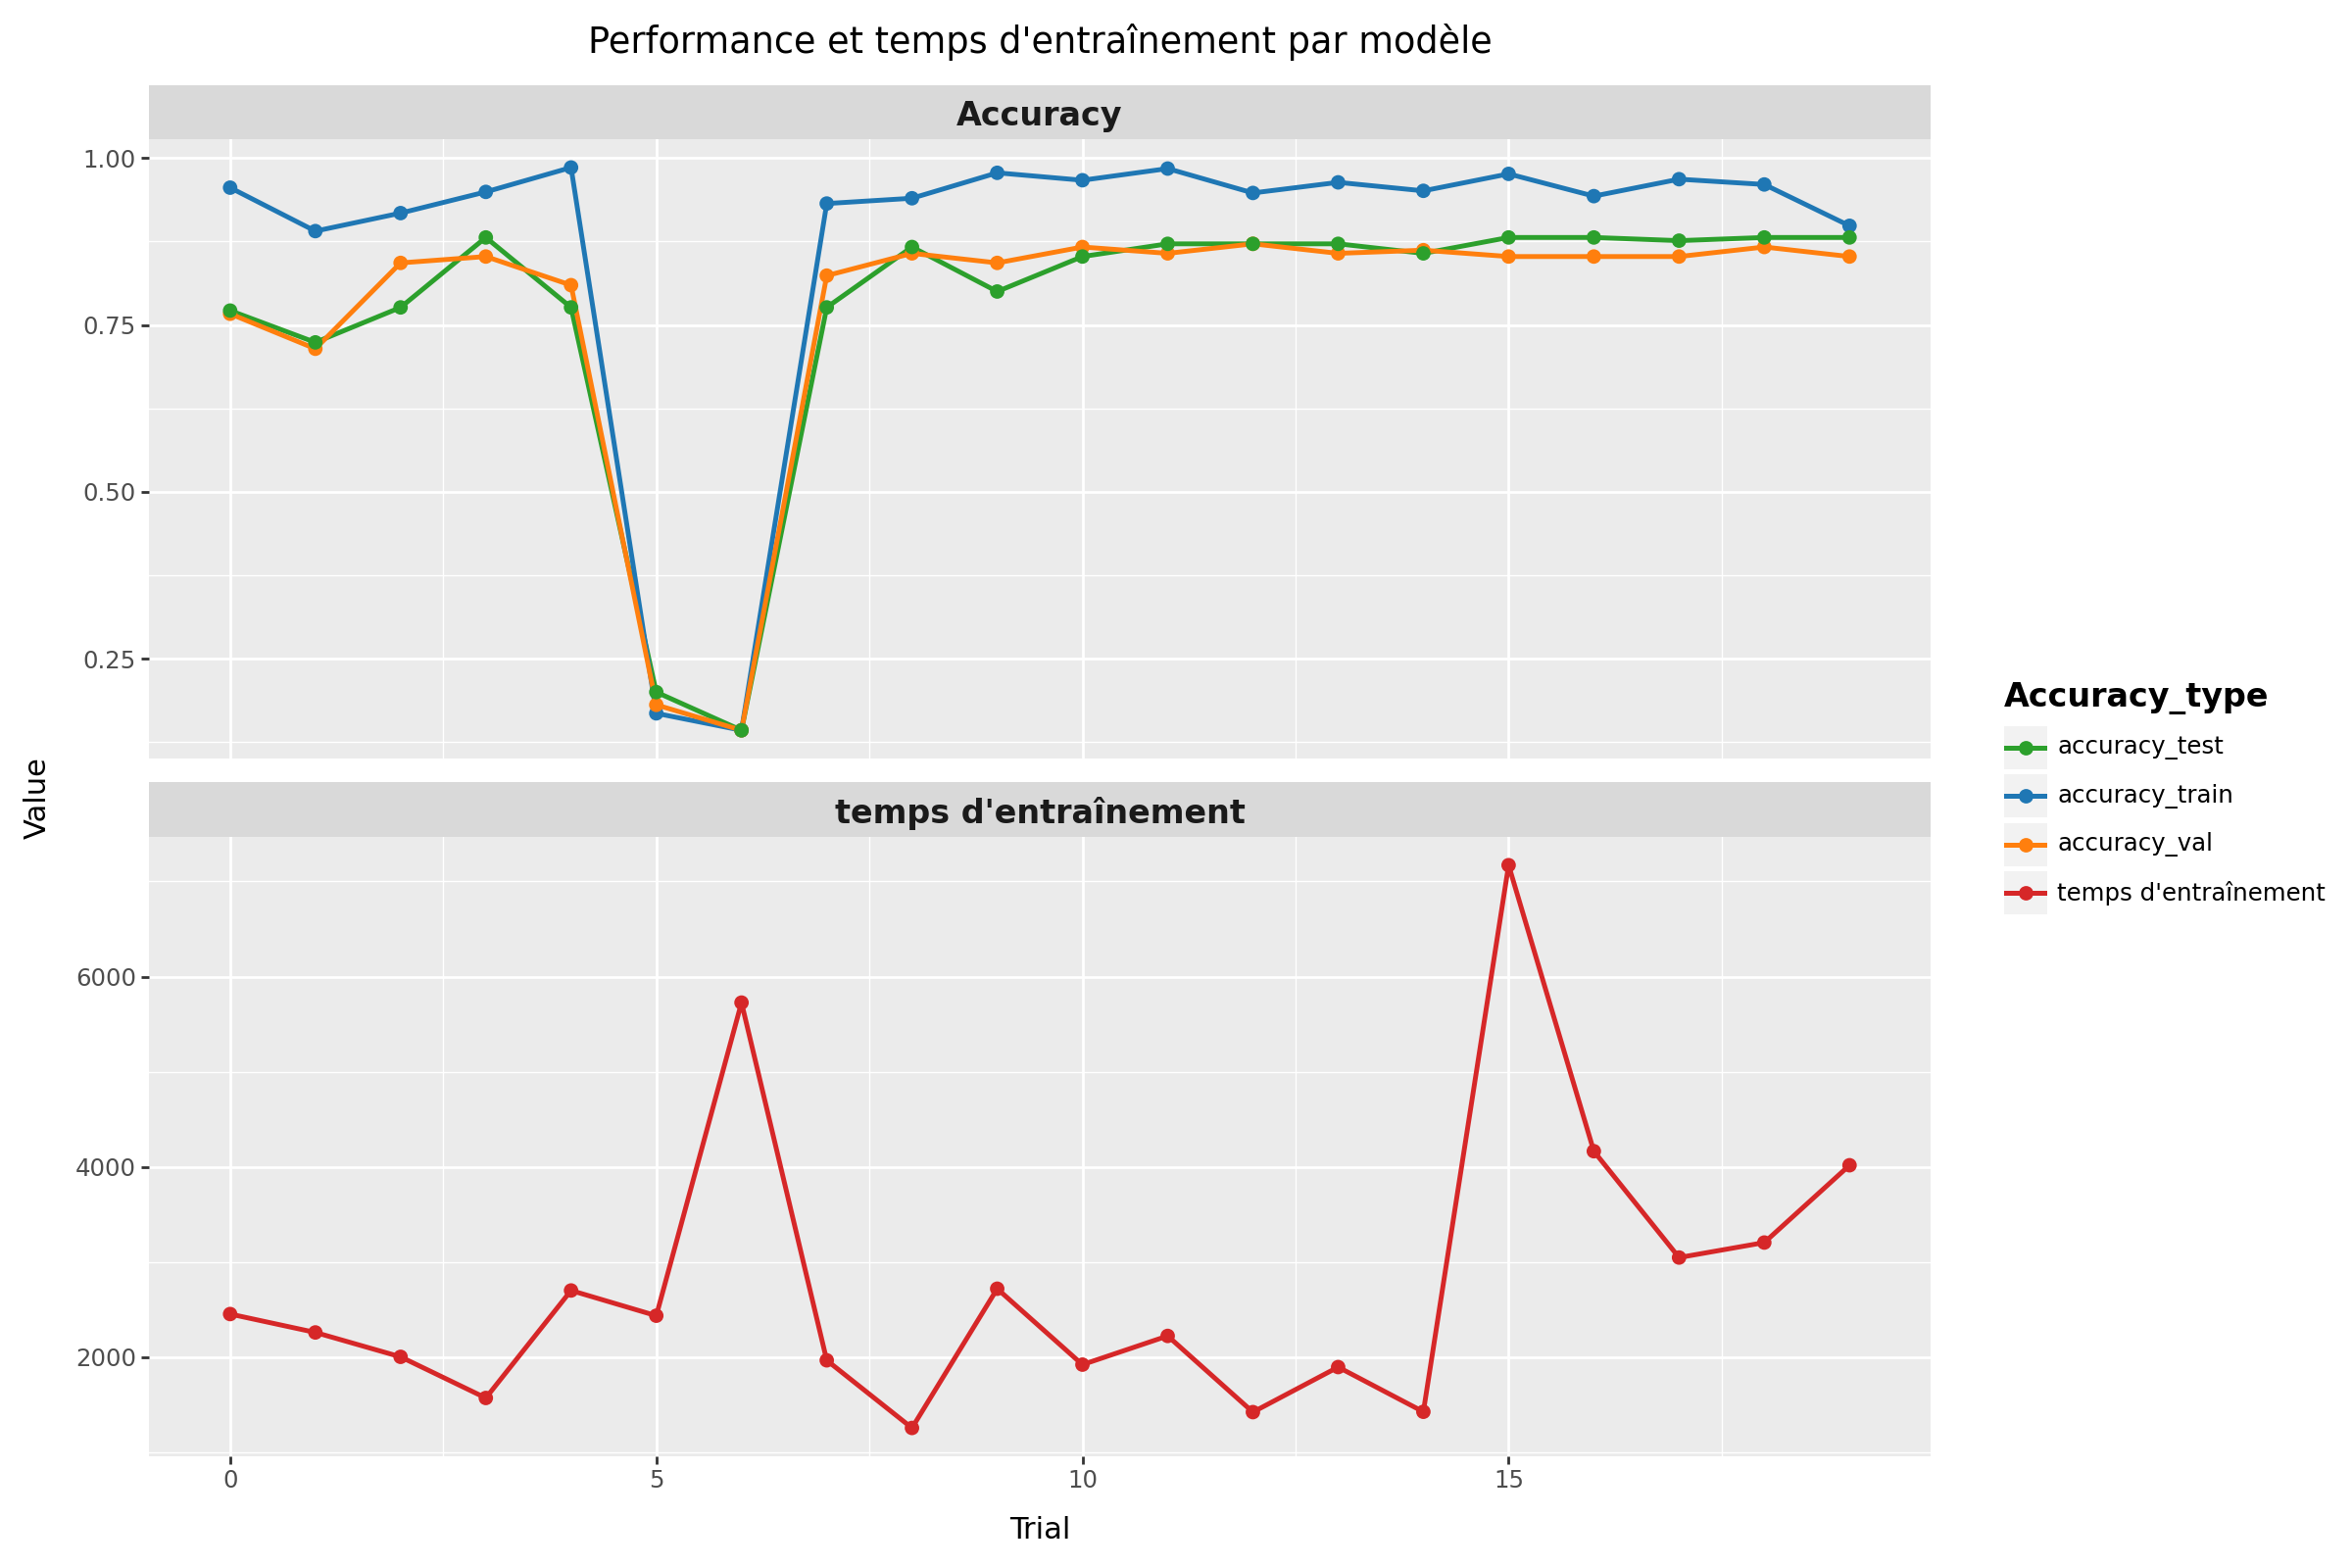

In [36]:
# Reshape en long format pour les accuracies
df_long = trials_df.melt(
    id_vars=["trial", "approche", "temps d'entraînement"],
    value_vars=["accuracy_train", "accuracy_val", "accuracy_test"],
    var_name="Accuracy_type",
    value_name="Accuracy"
)

# Création d’un dataframe "accuracy + temps" pour pouvoir faceter
df_acc = df_long.assign(Metric="Accuracy", value=df_long["Accuracy"])
df_time = trials_df.assign(Metric="temps d'entraînement", value=trials_df["temps d'entraînement"])

# Harmonisation des colonnes
df_time = df_time[["trial","approche","Metric","value"]]

# Fusionner
df_plot = pd.concat([
    df_acc[["trial","approche","Metric","Accuracy_type","value"]],
    df_time.assign(Accuracy_type="temps d'entraînement")
])

# Construction du plot avec facet_wrap
p = (
    ggplot(df_plot, aes(x="trial", y="value", color="Accuracy_type"))
    + geom_line(size=1)  
    + geom_point(size=2) 
    + facet_wrap("~Metric", scales="free_y", ncol=1)
    + labs(x="Trial", y="Value", title="Performance et temps d'entraînement par modèle")
    + scale_color_manual(  
        values={
            "accuracy_train": "#1f77b4",  
            "accuracy_val": "#ff7f0e",    
            "accuracy_test": "#2ca02c",   
            "temps d'entraînement": "#d62728"    
        }
    )
    + theme(
        figure_size=(12, 8),
        strip_text=element_text(size=12, weight='bold'),
        legend_title=element_text(size=12, weight='bold'),
        legend_position='right'  # tu peux aussi mettre 'none'
    )
)

# Affichage du plot
p.show()

L'analyse globale des performances des modèles optimisés montrent qu'a l'exeption de deux d'entre eux, les performances obtenues sont restées plutôt homogène et stable au cours des différents essais d'optimisation. Comme pour la configuration initiale, l'exactitude mesurée sur les données de validation et de test sont très proches. On note cependant une grande variabilité concernant les temps d'entrainement associés au différents modèles sans que cela s'accompagne d'un gain de performance notable. Dans la suite, les 5 meilleurs modèles en terme d'exactitude vont être comparés entre eux mais également avec le modèle initialement configuré afin de déterminer lequel consitue l'option la plus pertinente à privilégier.

In [37]:
# Selection des 5 meilleurs modèles
Resultats_opt_best = trials_df.sort_values("accuracy_val", ascending=False).head(5)

# Affichage des 5 lignes correspondnat aux 5 meilleurs modèles
Resultats_opt_best

,trial,value,dense_size,dropout,learning_rate,freeze_backbone,accuracy_train,accuracy_val,accuracy_test,temps d'entraînement,approche
12,12,0.417276,256,0.630530,0.002425,True,0.947619,0.871429,0.871429,1418.907182,Model_CvT_12
10,10,0.425503,256,0.602948,0.002046,True,0.966667,0.866667,0.852381,1918.407235,Model_CvT_10
18,18,0.425262,256,0.641118,0.000291,True,0.960317,0.866667,0.880952,3202.446241,Model_CvT_18
14,14,0.439281,256,0.614865,0.003146,True,0.950794,0.861905,0.857143,1422.448951,Model_CvT_14
11,11,0.427708,256,0.604469,0.002125,True,0.984127,0.857143,0.871429,2220.260604,Model_CvT_11


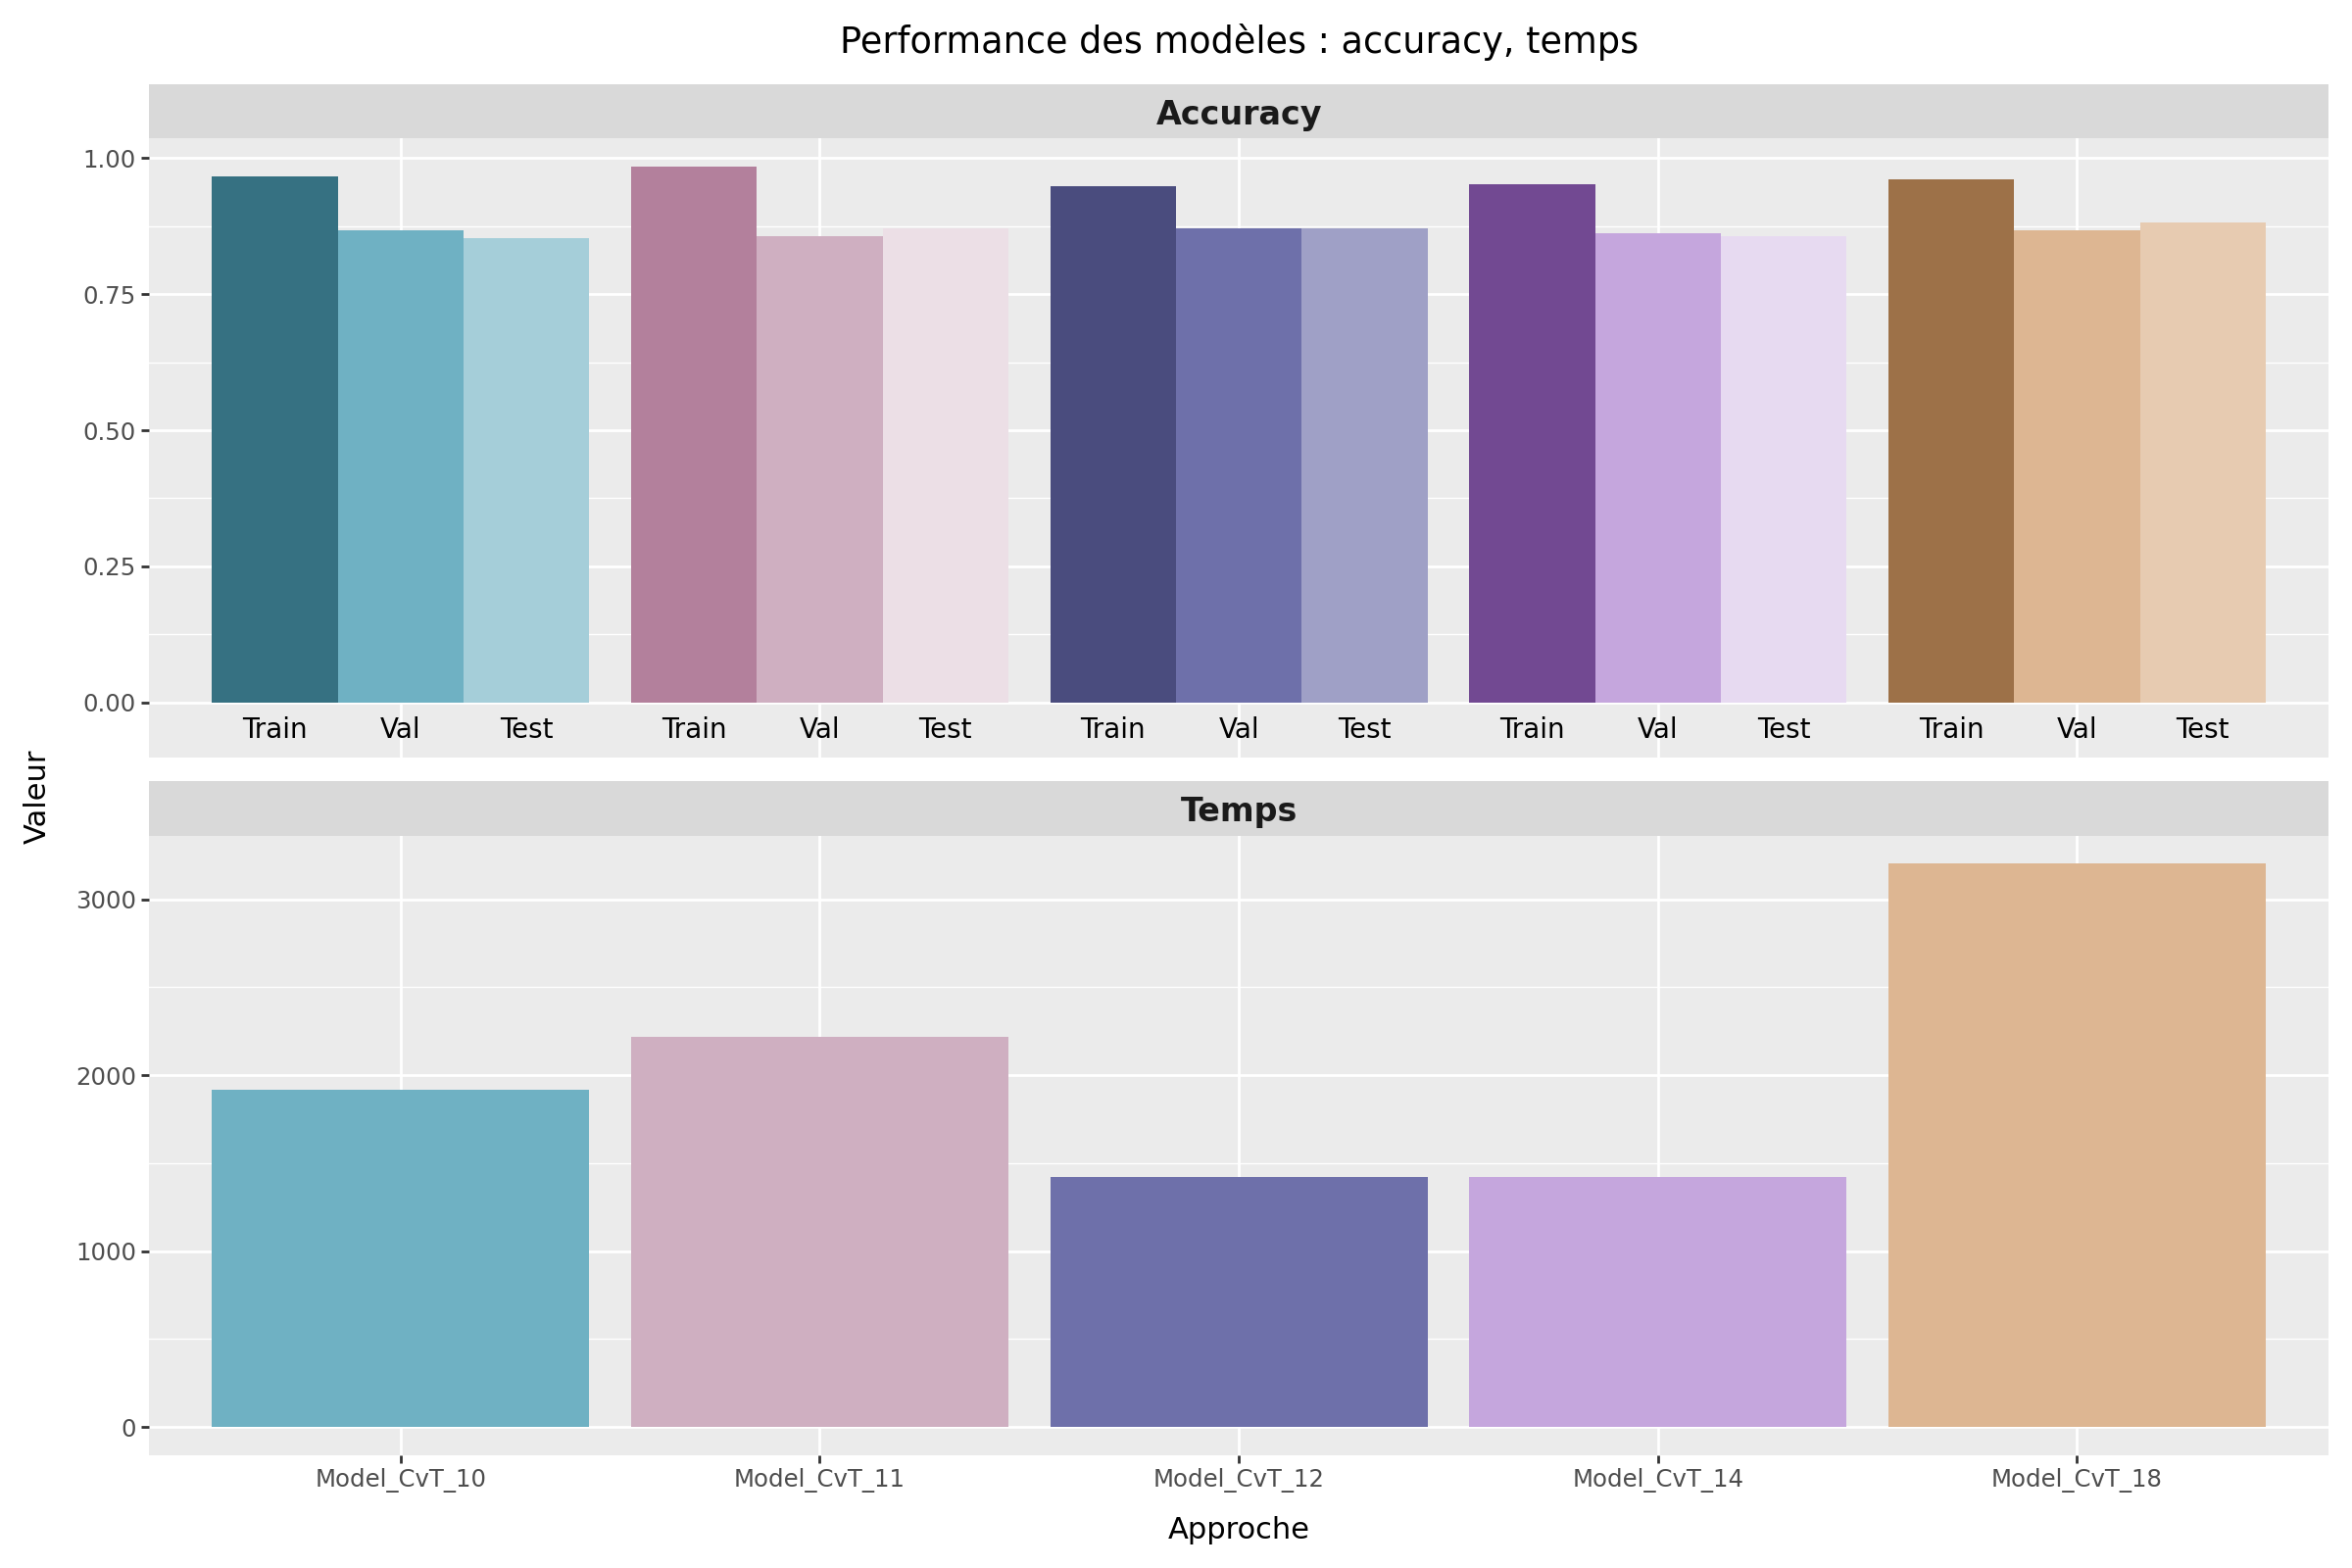

In [38]:
# Définition des différents type de barre
scores = ['Train', 'Validation', 'Test', "Temps d'entraînement"]

# Définition des couleurs en fonction des types d'information
couleurs_train = ['#4a4c7e', '#367182', '#9d7148', '#724992', '#b3809c']
couleurs_val = ['#6e70aa', '#6fb1c3', '#ddb692', '#c5a6dd', '#cfafc1']
couleurs_test = ['#9fa0c6', '#a5ced9', '#e7cbb1', '#e7daf1', '#ecdfe6']
couleurs_temps = ['#6e70aa', '#6fb1c3', '#ddb692', '#c5a6dd', '#cfafc1']

# Définition des modèles à afficher
modeles = Resultats_opt_best['approche']

# Construction d'un dictionnaire de couleur
custom_colors = {}
for i, modele in enumerate(modeles):
    custom_colors[f'Train_{modele}'] = couleurs_train[i]
    custom_colors[f'Validation_{modele}'] = couleurs_val[i]
    custom_colors[f'Test_{modele}'] = couleurs_test[i]
    custom_colors[f"Temps d'entraînement_{modele}"] = couleurs_temps[i]

# Définition de l'ordre d'apparition des barres
ordre = []
for modele in modeles:
    for score in scores:
        ordre.append(f"{score}_{modele}")

# Appel de la fonction
plot_resultats_modeles(df_resultats=Resultats_opt_best, ordre_score_approche= ordre, dict_couleurs=custom_colors, save_name="Comparaison_optimisation_CVT")

D’après le tableau, c'est l'essai numéro 12 qui a obtenu le meilleur score d’exactitude sur les données de validation. L’analyse du graphique représentant les résultats de performances des différentes combinaisons d’hyperparamètres ayant conduit aux 5 meilleurs valeurs d'exactitude sur les données de validation montre que les temps de calcul sont relativement variables, compris entre 1418 et 3202 secondes, et que les performances en termes d’exactitude mesurées sur les trois sous ensemble de données sont très proches les unes des autres. Néanmoins il est important de noter que l'optimisation n'a pas permis d'améliorer les performances par rapport à la configuration initialement testée dont l'entrainement a été plus court que celui de l'ensemble des modèles optimisés. Le modèle à privilégier correspond donc au modèle intialement configuré avant la phase d'optimisation. 

Avant de conclure on va analyser de facon plus détaillée la matrice de confusion et le rapport de classification de ce modèle.

# Evaluation finale du meilleur modèle 

In [39]:
# Initialisation du modèle avec l'approche initiale
best_model, optimizer, criterion, device, train_transform, val_transform = create_model_CVT(verbose=False)

# Chemin de sauvegarde du meilleur modèle
Save_path_best_model = f"../Models/CVT/model_CVT_best_weights_{date_str}.pth"

# Chargement du meilleur modèle CVT
best_model.load_state_dict(torch.load(Save_path_best_model, map_location=device))

<All keys matched successfully>

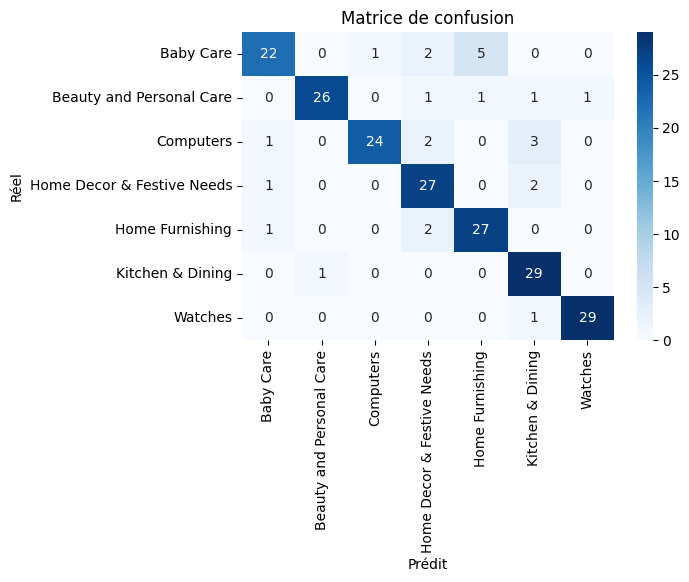

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.73      0.80        30
  Beauty and Personal Care       0.96      0.87      0.91        30
                 Computers       0.96      0.80      0.87        30
Home Decor & Festive Needs       0.79      0.90      0.84        30
           Home Furnishing       0.82      0.90      0.86        30
          Kitchen & Dining       0.81      0.97      0.88        30
                   Watches       0.97      0.97      0.97        30

                  accuracy                           0.88       210
                 macro avg       0.88      0.88      0.88       210
              weighted avg       0.88      0.88      0.88       210



In [40]:
# Prédictions
y_test_pred_proba, y_test_pred, y_test_true = predict_model(best_model, test_loader, device)

# Labels (indices de classes)
labels = sorted(np.unique(np.concatenate((y_test_true, y_test_pred))))

# Matrice de confusion
conf_mat = confusion_matrix(y_test_true, y_test_pred, labels=labels)

# Décodage des labels
labels_decoded = encoder.inverse_transform(labels)

# Dataframe pour affichage
df_cm = pd.DataFrame(conf_mat, index=labels_decoded, columns=labels_decoded)

# Construction de la heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.savefig(f'../Output/Matrice_de_confusion/Matrice_de_confusion_CVT.png', format='png')
plt.show()

# Rapport de classification
print(classification_report(y_test_true, y_test_pred, target_names=labels_decoded))


Les performances de ce modèle obtenu après optimisation ont déjà été décrit précédement. Pour rappel, on retrouve des performances très satisfaisantes sur les données test, avec une exactitude de 88%. La précision et le rappel moyens du modèle sont de 88 %. Ainsi, 88 % des prédictions effectuées par le modèle sont correctes, et 88 % des produits réellement présents dans chaque catégories sont bien identifiés.

Certaines catégories ressortent comme particulièrement bien prédites par le modèle. 

C’est le cas des catégories Watches, pour lesquelles les prédictions sont à la fois fiables (97 %) et exhaustives (97 %). De même, la catégorie Computer se distingue par une précision très élevée (96 %), indiquant que la majorité images prédites comme appartenant à la catégorie Computers appartiennent réellement à cette catégorie, même si le rappel de 80 % révèle que certaines image de cette catégorie ont été classés à tort dans d'autres catégories. 

La catégorie Beauty and Personal Care bénéficie également d’une excellente précision  de 96%, ce qui montre que lorsqu’un produit est classé dans cette catégorie, il l’est presque toujours à juste titre. Toutefois, son rappel de 87% indique que le modèle passe encore à côté de certains produits appartenant à cette catégorie.

La catégorie Kitchen and Dining est associé a un rappel très élevé (97%) ce qui indique que la majorité des vrais cas sont bien détectés, mais la précision plus faible de 81 % suggère que le modèle y place à tort des produits qui ne devraient pas y être.

Les autres classes (Baby Care, Home Decor & Festive Needs, Home Furnishing) présentent des performances légèrement plus limitées mais conservent un bon équilibre entre précision et rappel (environs 0.80-0.90).

## Analyse d'exemples de produits mal classés

In [41]:
# Préparation des noeuds (réels à gauche, prédits à droite)
left_labels  = [f"Réel: {c}"   for c in labels_decoded]
right_labels = [f"Prédit: {c}" for c in labels_decoded]
nodes = left_labels + right_labels

# Index des noeuds
n = len(labels_decoded)
idx_left  = {lab: i for i, lab in enumerate(left_labels)}
idx_right = {lab: i + n for i, lab in enumerate(right_labels)}

# Liens du Sankey: une ligne par (réel -> prédit) avec le volume = conf_mat[i,j]
sources, targets, values, link_colors, hovertexts = [], [], [], [], []

# Affichage de la diagonale (vrais positifs)
inclure_diagonale = True  

# Pour chaque couple de catégories réelles/prédites
for i, real_name in enumerate(labels_decoded):
    for j, pred_name in enumerate(labels_decoded):
        
        # Extraction de l'effectif de la matrice de confusion correspondant
        v = int(conf_mat[i, j])
        
        if v == 0:
            continue
        if (i == j) and not inclure_diagonale:
            continue
        
        # Nom à afficher a gauche
        s = idx_left[f"Réel: {real_name}"]
        
        # Nom a afficher à droite
        t = idx_right[f"Prédit: {pred_name}"]
        
        # Ajout des résultats dans les différentes listes
        sources.append(s)
        targets.append(t)
        values.append(v)

        # Définition des couleurs des liens : gris pour corrects, rouge pour erreurs
        if i == j:
            link_colors.append("rgba(120,120,120,0.35)")
        else:
            link_colors.append("rgba(200,50,50,0.5)")

        # Ajout des infos bulles à afficher 
        hovertexts.append(f"{real_name} → {pred_name}<br>Nombre: {v}")

# Définition des couleurs des noeuds
node_colors = (["#4c78a8"] * n) + (["#f58518"] * n)

# Construction du Sankey plot
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        label=nodes,
        pad=20,               
        thickness=22,          
        color=node_colors,
        line=dict(color="black", width=0.5),  
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        hovertemplate="%{customdata}<extra></extra>",
        customdata=hovertexts
    )
)])

# Mise en page de la figure
fig.update_layout(
    title_text="Flux Réel → Prédit (Sankey)",
    font=dict(
        family="Arial, Helvetica, sans-serif",  
        size=16,
        color="black"                           
    ),
    height=max(600, 90 * len(labels_decoded)),
    width=800,
    margin=dict(l=10, r=10, t=50, b=10)
)

# Sauvegarde de la figure
fig.write_image(f"../Output/Erreur_classification/Sankey_{date_str}.png")


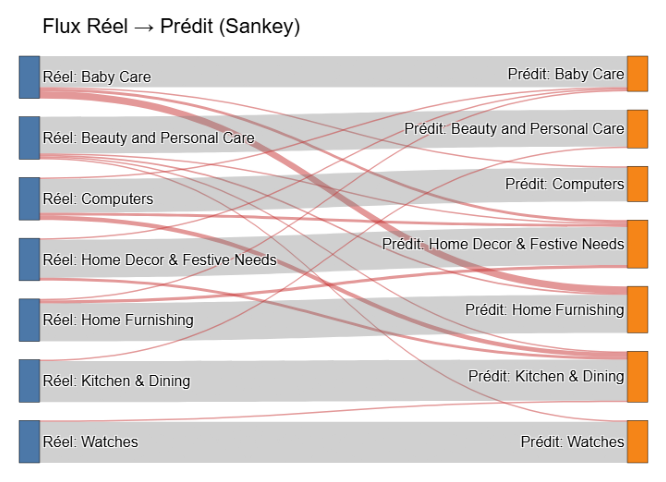

In [42]:
# Affichage de la figure
img = mpimg.imread(f"../Output/Erreur_classification/Sankey_{date_str}.png")
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off') 
plt.show()

Ce Sankey plot permet de visualiser de manière plus claire les différentes erreurs de prédictions du modèle. On remarque notamment que les 4 produits de la catégories Beauty and Personnal care mal classés ont été prédits comment appartenant a 4 catégorie différentes illustrant une certaine dispersion des erreurs. En revanche les 8 images de la catégorie Baby care ont été confondues avec seulement trois catégories ce qui indiquent une meilleure cohérence dans les erreurs. On peut aller plus loin en complétant cette analyse par l'étude des images mal classéees afin de mieux comprendre la nature des erreures commises par le modèle.

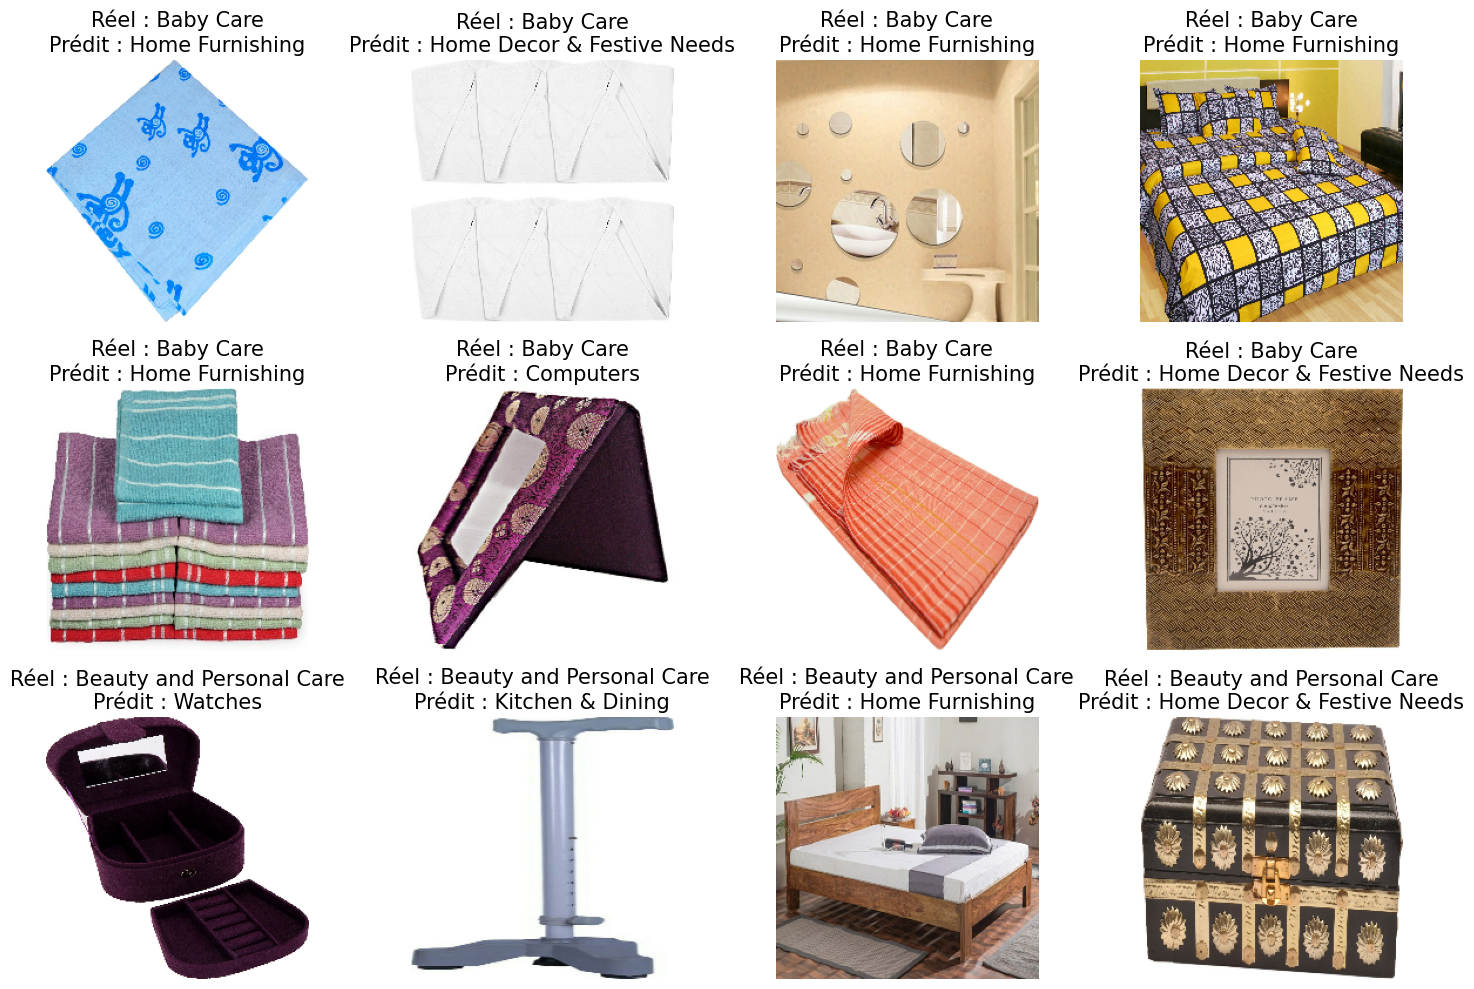

In [43]:
# Extraction des images du jeu de test
Images_test = np.concatenate([x for x, y in dataset_test], axis=0)

# Retour aux labels textuels des catégories
y_true_labels = encoder.inverse_transform(y_test_true)
y_pred_labels = encoder.inverse_transform(y_test_pred)

# Identification des indices correspondant aux mauvaises prédictions
indices_incorrects = np.where(y_test_true != y_test_pred)[0]

# Affichage de n images correspondantes
n = 12

# Initialisation de la figure
plt.figure(figsize=(15, 10))

# Pour chaque produits mal classés affichage de l'image correspondante
for i, idx in enumerate(indices_incorrects[:n]):
    plt.subplot(3, 4, i + 1)
    img = array_to_img(Images_test[idx]) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Réel : {y_true_labels[idx]}\nPrédit : {y_pred_labels[idx]}", fontsize=15)

# Ajustement de la figure
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig(f'../Output/Erreur_classification/Erreur_classification.png', format='png')

# Affichage de la figure
plt.show()


Les 12 premières images mal classifiées parmis les 19 correspondent à des produits de la catégorie Baby Care et de la catégorie Beauty and personnal Care. On remarque que les erreurs se répartissent vers plusieurs catégories. En particulier concernant la catégorie Baby Care, comme indiqué dans la matrice de confusion:
- 5 produits ont été classés dans la catégorie Home Furnishing
- 1 produit a été classé dans la catégorie Computers
- 2 produits ont été classés dans la catégorie Home Decor & Festive needs

Ces erreurs de prédictions pourraient s'expliquer par différents facteurs. (1) Tout d'abord on peut remarquer que certains produits de puériculture mal classés partagent des similitudes très importantes avec des produits d'autres catégories. C'est le cas de la serviette corerspondant à un type de produit que l'on peut également frequemment retrouver dans la catégorie Home Furnishing. De même le coffret de beauté présente des ressemblances avec certains éléments de décorations présent dans la catégorie Home Decor & Festive Needs. (2) Concernant la canne a trépieds, la prédiction de la catégorie Kitchen & Dining pourrait s'expliquer par une sous représentation de ce type de produits dans la catégorie Beauty and Personnal Care des données d'entrainement. Le modèle n’a donc peut être pas vu  d'exemples similaires pour bien apprendre à les identifier comme appartenant à la catégorie Beaty and Personnal Care. (3) Enfin, pour d'autre cas, il serait plus probable d'envvisager une erreur d'annotation des produits par les vendeurs. Par exemple la parure de lit annotée dans la catégorie Baby Care correspond en fait à une parure de lit pour adulte et la prédiction faite par le modèle semble plus conforme à la réalité. Une situation similaire concerne le matelas, initialement annoté dans la catégorie Beauty and Personal Care, alors que la prédiction du modèle dans la catégorie Home Furnishing apparaît plus cohérente.

# Conclusions

Ce projet avait pour objectif de comparer les performances d'une nouvelle approche plus récente de classification d'images dans le cadre du projet de catégorisation automatique des produits de la plateforme de place de marché. La catégorisation des produits de la plateforme avait initialement été implémenté grâce à l'utilisation du modèle VGG16 et de la technique de transfert d'apprentissage ce qui avait permis de classer correctement environs 76% des produits de la plateforme. 

Dans le but d'améliorer ces résultats, un travail de recherche bibliographique a été entrepris et a permis d'identifier une architecture très prometteuse présenté en 2021 par Wu et ses collaborateur. Ce modèle correspond au modèle CvT et présente l'avantage de combiner les atouts des réseaux de neurones convolutifs qui permettent d'identifer des motifs locaux dans les images avec la puissance des mécanismes d'attention issus des transormers. 

Pour pouvoir comparer les deux approches de façon cohérente, une méthodologie de modélisation similaire à la première approche a été mis en place. En particulier les images ont été soummise aux mêmes étapes de prétraitement (redimensionnement et data augmentation sur les données d'entrainement) et le modèle a été adapté à la tache du projet de la même manière c'est à dire en remplacant la couche de sortie du modèle pré entrainé par une couche dense, suivi d'une couche de drop out et d'une nouvelle tête de classification permettant de prédire les 7 catégories de produits. L'entrainement a été soumis au même conditions c'est a dire au meme nombre d'époque et au même early stopping.

L'évaluation comparative des deux approches a montrée que le modèle CvT conduisait à des performances plus élevée que le modèle VGG16 avec une augmentation de 12 points de l'exactitude ainsi qu'une meilleure précision et un meilleur rappel global confirmé sur la majorité des catégories. De plus ces gains de performances s'accompagnent d'un temps d'entrainement légèrement réduit rendant cette approche à la fois plus performante et plus efficace. Grâce à ce gain de temps, il a été possible d’optimiser le modèle CvT en ajustant quatre hyperparamètres clés (la taille de la couche dense, le taux de dropout, le learning rate et le gel ou non des poids déjà appris lors de l'entrainement). L'optimisation n'a toutefois pas permis d'améliorer les performances du modèle.

En conclusion, le modèle CvT constitue une alternative robuste et efficace à VGG16, capable d’améliorer significativement la qualité de la catégorisation automatique des produits tout en réduisant le temps d’entraînement nécessaire. Ces résultats confirment la pertinence des architectures hybrides combinant convolutions et mécanismes d’attention pour des tâches de classification d’images, et ouvrent la voie à de futures optimisations intégrant d’autres variantes de Vision Transformers ou des approches multimodales pour encore renforcer la performance et la généralisation du modèle.